In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_113415/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def mean_error(true,prediction):
    return np.nanmean(prediction - true)

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

def latituded_weighted_bias(true,prediction,lats):
    diff = prediction-true
#     print(diff[0])
    weights = np.cos(np.deg2rad(lats))
#     print(weights[0])
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
#     print(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
#     print(masked[0])
    weighted_average = np.ma.average(masked,weights=weights2d)
#     print(weighted_average)
    return weighted_average




In [33]:
## MAIN SCRIPT
## **** CHANGE FILES AND DATES HERE

def rmse_time_series_plot_and_maps(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

#     analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
#     analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_3_40MEM_individual_ens_member_20110101_20110601/mean_output/out.nc'
    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_5_40MEM_individual_ens_member_20110101_20110601/mean_output_gues/out.nc'

    ## ERA5 crash tests
    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights_MEM1_eq_MEM2/mean_output/out.nc'
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_crash_ens_members_test/mean_output/out.nc'

    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/TROY_ERA5_RESULTS_TEST2/mean_output/out.nc'
#     analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/iterative1_speedystatesfixed_offbyonebugfixed_hybrid_1_5_1_3/mean.nc'
    ### THIS IS THE OLD Hybrid MEAN 1.3,1.3 ## BEFORE BUGG FIXES
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal/mean/mean.nc'
    '''
    
    
    ANAL
    
    
    '''
    ### ERA5  
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/mean_output/out.nc'
    

    spread_file_ERA5 = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/sprd_output/out.nc'
    
    
    spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_3_40MEM_individual_ens_member_20110101_20110601/sprd_output/out.nc'
#     spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/sprd.nc' 
    
    # SPREAD FILES
    ds_spread_ERA5 = xr.open_dataset(spread_file_ERA5)
    ds_spread_speedy = xr.open_dataset(spread_file_speedy)
    

    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
    enddate = datetime(2011,12,31,18)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4
    
    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .2:
        level_in_era = 2
    level_era = level_in_era

    var_da = variable_speedy
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
    if variable_speedy == 'ps':
        variable_era = 'logp'
        
    
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')
    # FOR ERA5
    timestep_6hrly = 6
    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        if variable_speedy == 'ps': # don't select level if variable is 'ps'
            ds_nature = xr.open_dataset(nature_file)[var_era]
        else:
            ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
#     temp_500_nature = ds_nature.values

    # if surface pressure variable selected, then don't select a level. Theres only one for surface pressure..
    if var_era == 'logp':
        #convert to hPa for era5 ds
        temp_500_nature = np.exp(ds_nature.values) * 1000.0
        #convert to hPa for letkf analysis                         
        ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(time=time_slice) / 100.0
        ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(time=time_slice).values / 100.0
    else:     
        temp_500_nature = ds_nature.values
        ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
        ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    temp_500_analysis = ds_analysis_mean
    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    
    
#     temp_500_spread_era5 = ds_spread_ERA5[var_da].sel(lev=level).values
#     temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values
    


    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    #find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    smallest_index = min(speedy_index,nature_index,hybrid_index)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    else:
        length = hybrid_index
    print('the smallest length is',length)
    
    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    global_average_ensemble_spread_era5 = np.zeros((length))
    global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))

    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))
    
    analysis_bias = np.zeros((length))
    analysis_bias_speedy = np.zeros((length))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))
    
    print('Test unit check:')
    print(ds_analysis_mean[0])

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    
    
    for i in range(length):
#         analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
#         analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    
        analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
        analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
        
        analysis_bias[i] = latituded_weighted_bias(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_bias_speedy[i] = latituded_weighted_bias(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        
#         global_average_ensemble_spread_era5[i] = np.average(temp_500_spread_era5[i,:,:])
#         global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP.')
    
    ############################
    # LOAD TROYS MEAN ANAL

    # Define the base path for the files
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal'
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights/'

    ### ERA 5 crash test
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/'
#     troy_anal_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/mean_output/out.nc'
    ### ERA5 1 year run worked path
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_weights_sourcecodeupdated_1_20_24/'
    
    #### HYBRID NEW 1_3_1_3
    hybrid_base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_original_weights_20110101_20120101/'

    # Define the variable name, level, and time slice
    start_year = 2011
    end_year = 2011

    # startdate = datetime(2011,1,1,0)
    # enddate = datetime(2011,6,1,0)
    time_slice = slice(startdate,enddate)

    # level = 0.95 #0.2#0.95#0.51
    # level_era = 7 #2#7 #4

    # var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
    # var_da =  't'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    
    ## ADDING MEAN of Hybrid
    path_mean_anal_hybrid_retest = hybrid_base_path + 'mean_output/out.nc'
    if variable_speedy == 'ps':
        ds_mean_anal_hybrid_retest_1_3_1_3 = xr.open_dataset(path_mean_anal_hybrid_retest)[var_da].sel(time=time_slice) / 100.0
    else:    
        ds_mean_anal_hybrid_retest_1_3_1_3 = xr.open_dataset(path_mean_anal_hybrid_retest)[var_da].sel(lev=level, time=time_slice)

    # SPREAD OF HYBRID
#     spread_file_hybrid = hybrid_base_path + 'sprd_output/out.nc'
#     ds_spread_hybrid = xr.open_dataset(spread_file_hybrid)
#     temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
#     global_average_ensemble_spread_hybrid = np.zeros((length))
    
#     # Create an empty list to store the datasets
#     ds_list = []

#     # ens member list
#     ens_member_list = range(1,40+1)
# #     print("opening all files...")
#     # Loop through the member numbers and read in the corresponding files
#     for member_number in ens_member_list:
#         file_path = f'{base_path}/{member_number:03d}_output/out.nc'
#         # file_path = f'{base_path}/{member_number:03d}_output/{member_number:03d}.nc'
#         ds = xr.open_dataset(file_path)[var_da].sel(lev=level, time=time_slice)
#         ds_list.append(ds)
#     print('shape test =', np.shape(ds_list))
    
    
    
#     ds_anal_troy = xr.open_dataset(troy_anal_path)[var_da].sel(lev=level, time=time_slice)
#     print('shape test =', np.shape(ds_anal_troy))
    
    # print('ds_list[0] =',ds_list[0])

    # Assign each element in ds_list to be called ds_member_{i}
    # for i, ds in enumerate(ds_list, start=1):
    #     globals()[f'ds_member_{i}'] = ds

    # print(ds_member_1) 

    lats = ds_nature.Lat

    # analysis_error is for maps, see its a 3d array, 
    # MAKING analysis_rmse now

    print('MAKING zeros arrays..')
#     quantity_of_ens_members = 40
#     analysis_rmse_object = np.zeros((quantity_of_ens_members, length))
    
#     anal_rmse_troy = np.zeros((length))
#     anal_error_troy = np.zeros((length,ygrid,xgrid))
    anal_mean_error_hybrid_1_3_1_3 = np.zeros((length,ygrid,xgrid))
    anal_mean_rmse_hybrid_1_3_1_3 = np.zeros((length))
    
    anal_bias_hybrid_1_3_1_3 = np.zeros((length))
    # check shape, yes they are equal and vibing
    # print('new = ',np.shape(analysis_rmse_object[0]))
    # print('old = ', np.shape(analysis_rmse_1))

#     print('looping through each ERA5 ens_member at every timestep..')
#     counter = 0
#     for member_number in range(0,40):
#         # loop through each timestep
#         counter = counter + 1
#         print('MEM counter = ',counter)
#         for l in range(length):
#     #     for l in range(length):
#             analysis_rmse_object[member_number,l] = latituded_weighted_rmse(temp_500_nature[l,:,:],ds_list[member_number][l,:,:],lats)
    
        
    ##### and calc for mem 1 with length == 3:
    # analysis_rmse_mem1 = latituded_weighted_rmse(temp_500_nature[3,:,:],ds_list[1][3,:,:],lats)
    # print(analysis_rmse_mem1)
    #####

    # print('analysis_rmse_object[0] =',analysis_rmse_object[0])
    # print('analysis_rmse_object[39] =',analysis_rmse_object[39])    
    print('Calc hybrid analysis_error and bias')
    
    for i in range(length):
        anal_mean_error_hybrid_1_3_1_3[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
        
        anal_bias_hybrid_1_3_1_3[i] = latituded_weighted_bias(temp_500_nature[i,:,:],ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:],lats)
        
    print('Done with speedy trained hybrid analysis.')
    
    # take average of anal_bias_hybrid_1_3_1_3
    global_mean_anal_bias_hybrid_1_3_1_3 = np.average(anal_bias_hybrid_1_3_1_3[24::])
    
    print('global mean bias of speedy trained hybrid analysis = ', global_mean_anal_bias_hybrid_1_3_1_3)
    
    # take avg of speedy_anal_bias 
    global_mean_anal_bias_speedy = np.average(analysis_bias_speedy[24::])
    print('global mean bias of speedy analysis = ', global_mean_anal_bias_speedy)
    
#     if var_era == 'Specific_Humidity': #convert to g/kg
#         global_mean_anal_bias_hybrid_1_3_1_3 = global_mean_anal_bias_hybrid_1_3_1_3*1000
#         global_mean_anal_bias_speedy = global_mean_anal_bias_speedy*1000
        
    
    
    #########################################################
    # MAKE MAP FROM ABOVE 

    ''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
    ####### WHICH AVGERAGE ERROR DO YOU WANT?? I want the analysis error of the mean ERA5
    if var_era == 'Temperature':
        units='(K)'
    if var_era == 'Specific_Humidity':
        units='(g/kg)'
    if var_era == 'V-wind':
        units='(m/s)'
    if var_era == 'U-wind':
        units='(m/s)'
    if var_era == 'logp':
        units='hPa' # converted above
    print(units)
    if level == .95:
        title_level = 'Low Level '
    if level == .2:
        title_level = '200 hPa '
    print(title_level)
    if var_era == 'Specific_Humidity':
        title_var_era = 'Specific Humidity'
    if var_era == 'V-wind':
        title_var_era = "Meridional Wind"
    if var_era == 'Temperature':
        title_var_era = 'Temperature'
    if var_era == 'U-wind':
        title_var_era = 'Zonal Wind'
    if var_era == 'logp':
        title_var_era = 'Surface Pressure'
    print(title_var_era)
    
    obs_network_file = '/skydata2/troyarcomano/letkf-hybrid-speedy/obs/networks/uniform.txt'
    network_ij = np.loadtxt(obs_network_file,skiprows=2,dtype=int)
    network_ij = network_ij - 1
    
    
    #### TAKING OUT ABSOLUTE VALUE 
#     averaged_error = np.average(abs(analysis_error[24::,:,:]),axis=0)
    
    averaged_error = np.average((analysis_error[24::,:,:]),axis=0)
    averaged_error_speedy = np.average((analysis_error_speedy[24::,:,:]),axis=0)
    
  
    # SeeeEEeee no abs value taken so its the bias
    
    lat = ds_analysis_mean.lat.values
    lon = ds_analysis_mean.lon.values  
#     lons2d, lats2d = np.meshgrid(lon,lat)

    print('Now plotting and meshing...')
    
    # data for plot Hybrid and Speedy Map
    if var_era == 'Specific_Humidity':
        cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
        cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
    else: 
        cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
        cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    
    # data for plot difference 
    diff = averaged_error - averaged_error_speedy
    if var_era == 'Specific_Humidity':
        cyclic_data_diff, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
    else:
        cyclic_data_diff, cyclic_lons = add_cyclic_point(diff, coord=lon)
        
#     print('cyclic_data ', cyclic_data, np.shape(cyclic_data))
#     print('cyclic_lons ', cyclic_lons, np.shape(cyclic_lons))
    
    lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     lons2d, lats2d = np.meshgrid(lon,lat)
    
    ## SET VMIN AND VMAX using old code
    if level == .95 and var_era == 'Temperature':
        adapted_range = np.arange(-5.05,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)

    if level == .2 and var_era == 'Temperature':
#         adapted_range = np.arange(0,.1,.001)
#         adapted_difference_range = np.arange(-.05,.05,.001)
        adapted_range = np.arange(-5.05,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
        
    if level == .95 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(-3,3,.05)
        adapted_difference_range = np.arange(-2,2,.001)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
        
    if level == .2 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(-.1,.1,.001)
        adapted_difference_range = np.arange(-.05,.05,.001)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .2 and var_era == 'V-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .95 and var_era == 'V-wind':
        adapted_range = np.arange(-5,5,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .95 and var_era == 'U-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .2 and var_era == 'U-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    
    ## ERA5 trained Hybrid Map
    
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Bias '+ units)
#     axs[0].set_title('LETKF Analysis Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'ERA5 trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Bias '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
#     plt.tight_layout()
#     plt.show()
#     ###############
#     # data for plot Hybrid and Speedy Map
    
    
    averaged_error_speedyhybrid = np.average((anal_mean_error_hybrid_1_3_1_3[24::,:,:]),axis=0) # this is average at each grid point. all I need to do is subtract 1 number from all these
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedyhybrid*1000, coord=lon)
#         cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
#     else: 
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedyhybrid, coord=lon)
#         cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    
#     # data for plot difference 
#     diff = averaged_error_speedyhybrid - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data_diff, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data_diff, cyclic_lons = add_cyclic_point(diff, coord=lon)
        
# #     print('cyclic_data ', cyclic_data, np.shape(cyclic_data))
# #     print('cyclic_lons ', cyclic_lons, np.shape(cyclic_lons))
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
    
    
    
#      ## SPEEDY trained Hybrid Map
    
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Bias '+ units)
#     axs[0].set_title('LETKF Analysis Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'SPEEDY trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Bias '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
#     plt.tight_layout()
#     plt.show()
    
#     # VARIABILITY PLOT BELOW
#     # take global mean and subtract at every gridpoint
#     # here it is: latitude weighted -> global_mean_anal_bias_hybrid_1_3_1_3 
    
    
#     #global_mean_anal_bias_hybrid_1_3_1_3 = np.average(anal_bias_hybrid_1_3_1_3[24::])
# #     print('global mean bias of speedy trained hybrid analysis = ', global_mean_anal_bias_hybrid_1_3_1_3)
# #     # take avg of speedy_anal_bias 
# #     global_mean_anal_bias_speedy = np.average(analysis_bias_speedy[24::])
# #     print('global mean bias of speedy analysis = ', global_mean_anal_bias_speedy)
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data_bias_global_mean_departure, cyclic_lons = add_cyclic_point((global_mean_anal_bias_hybrid_1_3_1_3*1000) - (averaged_error_speedyhybrid*1000), coord=lon)
#         cyclic_data_speedy_bias_global_mean_depature, cyclic_lons = add_cyclic_point((global_mean_anal_bias_speedy*1000)- (averaged_error_speedy*1000), coord=lon)
#     else: 
#         cyclic_data_bias_global_mean_departure, cyclic_lons = add_cyclic_point((global_mean_anal_bias_hybrid_1_3_1_3) - (averaged_error_speedyhybrid), coord=lon)
#         cyclic_data_speedy_bias_global_mean_depature, cyclic_lons = add_cyclic_point((global_mean_anal_bias_speedy)- (averaged_error_speedy), coord=lon)

#     # data for plot difference 
#     diff_variability = (global_mean_anal_bias_hybrid_1_3_1_3 - averaged_error_speedyhybrid) - (global_mean_anal_bias_speedy - averaged_error_speedy)
#     if var_era == 'Specific_Humidity':
#         cyclic_data_diff_variability, cyclic_lons = add_cyclic_point(diff_variability*1000, coord=lon)
#     else:
#         cyclic_data_diff_variability, cyclic_lons = add_cyclic_point(diff_variability, coord=lon)
        
#     ## SPEEDY trained Hybrid
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data_bias_global_mean_departure, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='inferno', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Departure from Global Mean '+ units)
#     axs[0].set_title('LETKF Global Analysis Mean Bias - Analysis Gridpoint Mean Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'SPEEDY trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy_bias_global_mean_depature, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='inferno', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Departure from Global Mean '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff_variability, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')

    
#     plt.tight_layout()
#     plt.show()
    
    
    
    # Now plot speedy but first calculate
    
    #bias
#     analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]

    
#     print('bias squared and in g/kg ..\n', squared_bias_g_kg)
    
#     print(np.shape(squared_bias_g_kg))
    #average all the squared differences through time
    if variable_speedy == 'q':
        MSE_speedy = np.average((((analysis_error_speedy[24::,:,:])*1000)**2.0),axis=0)
    else: 
        MSE_speedy = np.average((((analysis_error_speedy[24::,:,:]))**2.0),axis=0)
    
    print("MSE speedy \n", MSE_speedy)
    # make points for plotting using cyclic point
    cyclic_data_MSE_speedy, cyclic_lons = add_cyclic_point(MSE_speedy, coord=lon)
    
    print('cyclic_data_MSE \n', cyclic_data_MSE_speedy)
    
    # take an average of the biases
    averaged_error_speedy = np.average((analysis_error_speedy[24::,:,:]),axis=0)
    
#     if variable_speedy == 'q':
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 
#     # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
#     else:
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0 # g/kg
        
        
        
    cyclic_data_bias_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    #square each bias value
    if variable_speedy == 'q':
        Bias_squared_speedy = (cyclic_data_bias_speedy*1000)**2.0
    else:
        Bias_squared_speedy = cyclic_data_bias_speedy**2.0
    #calculate variance
    Variance_speedy = cyclic_data_MSE_speedy - Bias_squared_speedy
    #calculate std devia
    standard_deviation_speedy = np.sqrt(Variance_speedy)
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
    print('variable_speedy = ', variable_speedy)
    
    
    if variable_speedy == 'q':
        imshow_v_max = 8 
    if variable_speedy == 'v':
        imshow_v_max = 30
    if variable_speedy == 'u':
        imshow_v_max = 30
    if variable_speedy == 't':
        imshow_v_max = 16
    if variable_speedy == 'ps':
        imshow_v_max = 200
        
    print('imshow_v_max = ', imshow_v_max)
    imshowsquared_units = units + '^2'
    print('imshowsquared_units ', imshowsquared_units)
    #hPa"R\u00b2 score EO: {:0.2f}".format(r2_train_EO)
    
    fig, axs = plt.subplots(4, 1, figsize=(34, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    ipickcolormap = 'viridis'
    img1 = axs[0].imshow(cyclic_data_MSE_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
    cbar1.set_label(imshowsquared_units)
    axs[0].set_title('LETKF SPEEDY\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error')

    # Plot SPEEDY

    
    img2 = axs[1].imshow(Bias_squared_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax=imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[1].coastlines()
#     axs[1].gridlines()
    cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
    cbar2.set_label(imshowsquared_units)  # Change label for Data 2
    axs[1].set_title('Bias Squared')

    # PLOT variance = MS - Bias**2.0

    img3 = axs[2].imshow(Variance_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[2].coastlines()
#     axs[2].gridlines()
    cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
    cbar3.set_label(imshowsquared_units)
    axs[2].set_title('Variance')
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
    
    
    standard_deviation_speedy = np.sqrt(Variance_speedy)
    
    img4 = axs[3].imshow(standard_deviation_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[3].coastlines()
#     axs[2].gridlines()
    cbar4 = plt.colorbar(img4, ax=axs[3], orientation='vertical', fraction=0.03, pad=0.005)
    cbar4.set_label(units)
    axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    plt.show()
    
    
    
    
    
    #############
    bias_hybrid_now = np.zeros((length,ygrid,xgrid))
    
    for i in range(length):
        bias_hybrid_now[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
    if variable_speedy == 'q':
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 
    # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
    else:
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0 # g/kg
    print('bias_hybrid_now_squared ', bias_hybrid_now_squared)
    
    cyclic_data_bias_sqaured_now, cyclic_lons = add_cyclic_point(bias_hybrid_now_squared, coord=lon)
    ####
    if variable_speedy == 'q':
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:]*1000)**2.0),axis=0) # g/kg
    else:
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:])**2.0),axis=0)
    
    cyclic_data_mse_now, cyclic_lons = add_cyclic_point(MSE_NOW,coord=lon)
    
    #####
    variance_now = cyclic_data_mse_now - cyclic_data_bias_sqaured_now
    std_dev_now = np.sqrt(variance_now)
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
    fig, axs = plt.subplots(4, 1, figsize=(34, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    img1 = axs[0].imshow(cyclic_data_mse_now, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
    cbar1.set_label(imshowsquared_units)
    axs[0].set_title('LETKF Speedy trained Hybrid\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error')
    
    
    img2 = axs[1].imshow(cyclic_data_bias_sqaured_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[1].coastlines()
    cbar2 = plt.colorbar(img2, ax=axs[1],orientation='vertical',fraction=0.03,pad=0.005)
    cbar2.set_label(imshowsquared_units)
    axs[1].set_title('Bias Squared')
    
    img3 = axs[2].imshow(variance_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[2].coastlines()
    cbar3 = plt.colorbar(img3, ax=axs[2],orientation='vertical',fraction=0.03,pad=0.005)
    cbar3.set_label(imshowsquared_units)
    axs[2].set_title('Variance')
    
    std_dev_now = np.sqrt(variance_now)
    
    img4 = axs[3].imshow(std_dev_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[3].coastlines()
    cbar4 = plt.colorbar(img4, ax=axs[3],orientation='vertical',fraction=0.03,pad=0.005)
    cbar4.set_label(units)
    axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    plt.show()
    
       #############
    bias_hybrid_now = np.zeros((length,ygrid,xgrid))
    
    for i in range(length):
        bias_hybrid_now[i,:,:] = ds_analysis_mean[i,:,:] - temp_500_nature[i,:,:]
    
    if variable_speedy == 'q':
        # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 # g/kg
        
    else: 
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0

    print('bias_hybrid_now_squared ', bias_hybrid_now_squared)
    
    cyclic_data_bias_sqaured_now, cyclic_lons = add_cyclic_point(bias_hybrid_now_squared, coord=lon)
    ####
    if variable_speedy == 'q':
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:]*1000)**2.0),axis=0) # g/kg
    else: 
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:])**2.0),axis=0) 
        
    cyclic_data_mse_now, cyclic_lons = add_cyclic_point(MSE_NOW,coord=lon)
    
    #####
    variance_now = cyclic_data_mse_now - cyclic_data_bias_sqaured_now
    std_dev_now = np.sqrt(variance_now)
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
    fig, axs = plt.subplots(4, 1, figsize=(34, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    img1 = axs[0].imshow(cyclic_data_mse_now, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
    cbar1.set_label(imshowsquared_units)
    axs[0].set_title('LETKF ERA5 trained Hybrid\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error')
    
    
    img2 = axs[1].imshow(cyclic_data_bias_sqaured_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[1].coastlines()
    cbar2 = plt.colorbar(img2, ax=axs[1],orientation='vertical',fraction=0.03,pad=0.005)
    cbar2.set_label(imshowsquared_units)
    axs[1].set_title('Bias Squared')
    
    img3 = axs[2].imshow(variance_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[2].coastlines()
    cbar3 = plt.colorbar(img3, ax=axs[2],orientation='vertical',fraction=0.03,pad=0.005)
    cbar3.set_label(imshowsquared_units)
    axs[2].set_title('Variance')
    
    std_dev_now = np.sqrt(variance_now)
    
    img4 = axs[3].imshow(std_dev_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[3].coastlines()
    cbar4 = plt.colorbar(img4, ax=axs[3],orientation='vertical',fraction=0.03,pad=0.005)
    cbar4.set_label(units)
    axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    plt.show()

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'q' (lat: 48, lon: 96)>
array([[1.831847e-06, 1.842766e-06, 1.831794e-06, ..., 1.870530e-06,
        1.858924e-06, 1.852949e-06],
       [1.981276e-06, 1.929611e-06, 1.916301e-06, ..., 1.974500e-06,
        1.968137e-06, 1.965899e-06],
       [2.008020e-06, 1.939521e-06, 1.934962e-06, ..., 2.131943e-06,
        2.171485e-06, 2.111867e-06],
       ...,
       [8.954502e-06, 9.602112e-06, 9.732233e-06, ..., 6.424174e-06,
        7.469660e-06, 8.358477e-06],
       [8.497247e-06, 8.791937e-06, 8.961232e-06, ..., 7.344539e-06,
        7.817524e-06, 8.212116e-06],
       [8.215678e-06, 8.249554e-06, 8.311014e-06, 

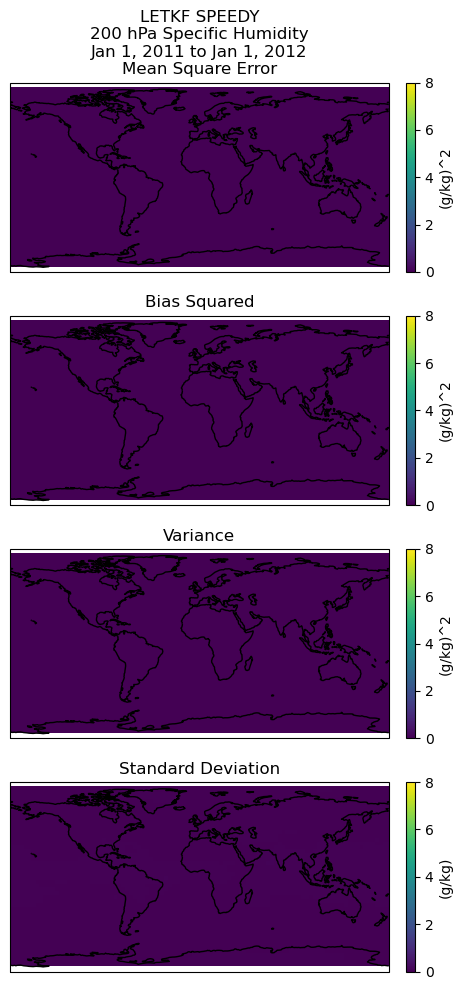

bias_hybrid_now_squared  [[0.00069958 0.00070649 0.00071291 ... 0.00068039 0.00068643 0.00069289]
 [0.00072137 0.00074242 0.00076128 ... 0.00065723 0.0006778  0.00069965]
 [0.00076197 0.00079571 0.0008258  ... 0.0006594  0.00069305 0.00072745]
 ...
 [0.0017184  0.00167158 0.00163423 ... 0.00190798 0.00184166 0.001776  ]
 [0.00157271 0.0015572  0.00154324 ... 0.00162365 0.00160712 0.00158946]
 [0.00141028 0.00141131 0.00141239 ... 0.0014071  0.0014083  0.00140925]]


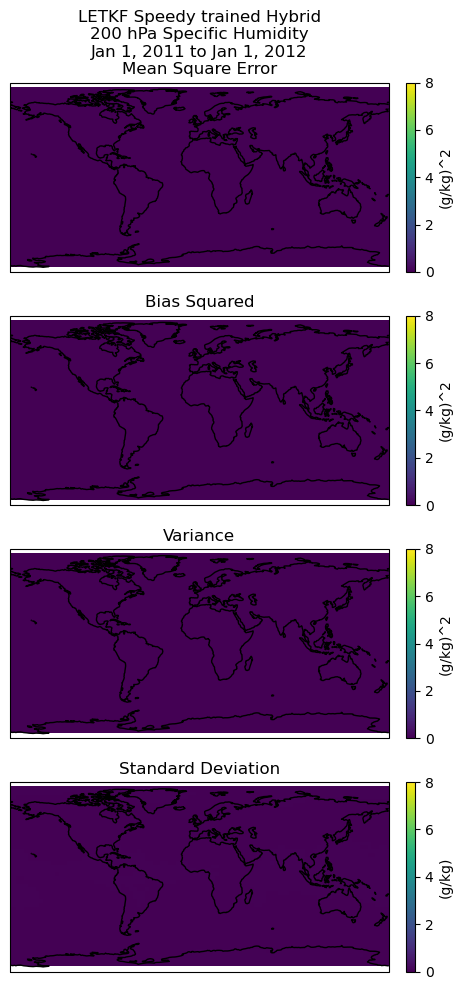

bias_hybrid_now_squared  [[5.02570920e-09 5.29745734e-09 4.99048031e-09 ... 5.54968687e-09
  5.57784197e-09 5.42139395e-09]
 [3.29129265e-09 4.32571868e-09 5.07286173e-09 ... 3.57090728e-09
  2.64080027e-09 2.34277925e-09]
 [4.44761790e-09 5.91938618e-09 6.79128724e-09 ... 4.58421121e-09
  3.60722229e-09 3.51586255e-09]
 ...
 [3.24239062e-07 5.11515314e-07 7.45177422e-07 ... 2.09937025e-08
  8.43821390e-08 1.73617204e-07]
 [5.84535568e-07 6.37860620e-07 7.09234486e-07 ... 1.83422787e-07
  3.39063434e-07 3.96672782e-07]
 [6.91450794e-07 6.86637112e-07 7.66512405e-07 ... 4.27302691e-07
  5.69268014e-07 5.68821761e-07]]


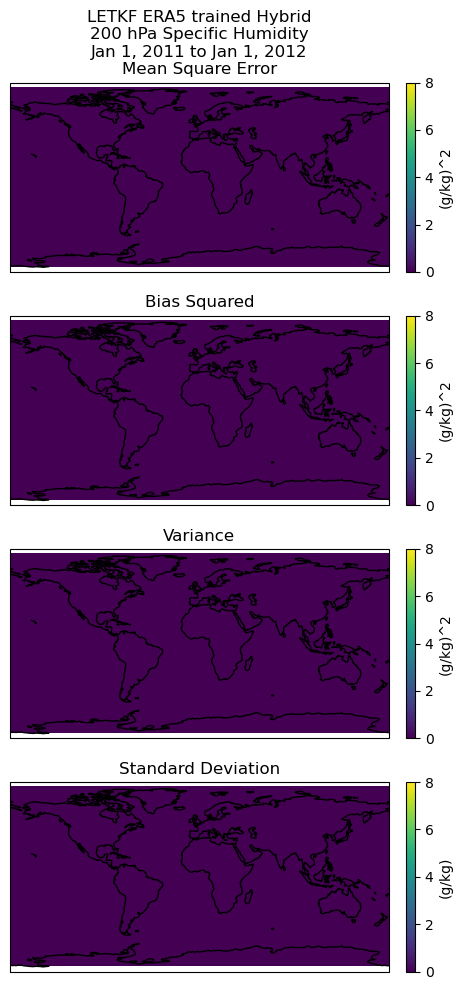

In [36]:
# TEST CELL an individual variable/level combination
rmse_time_series_plot_and_maps(.2,'q')

U-wind
you selected for variable = U-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'u' (lat: 48, lon: 96)>
array([[-3.029743e+00, -2.679650e+00, -2.031767e+00, ..., -4.775714e+00,
        -4.072998e+00, -3.412230e+00],
       [-1.895417e+00, -9.952622e-01, -3.785409e-03, ..., -3.447196e+00,
        -2.902961e+00, -2.504750e+00],
       [ 1.748495e+00,  1.478141e+00,  1.725679e+00, ...,  1.724417e+00,
         1.418538e+00,  2.308821e+00],
       ...,
       [-6.223951e+00, -7.784315e+00, -9.637932e+00, ..., -2.942321e+00,
        -4.228899e+00, -5.431843e+00],
       [-3.207884e+00, -3.665169e+00, -4.238963e+00, ..., -1.439776e+00,
        -1.330337e+00, -2.422269e+00],
       [ 7.705491e-01,  1.030452e+00,  1.

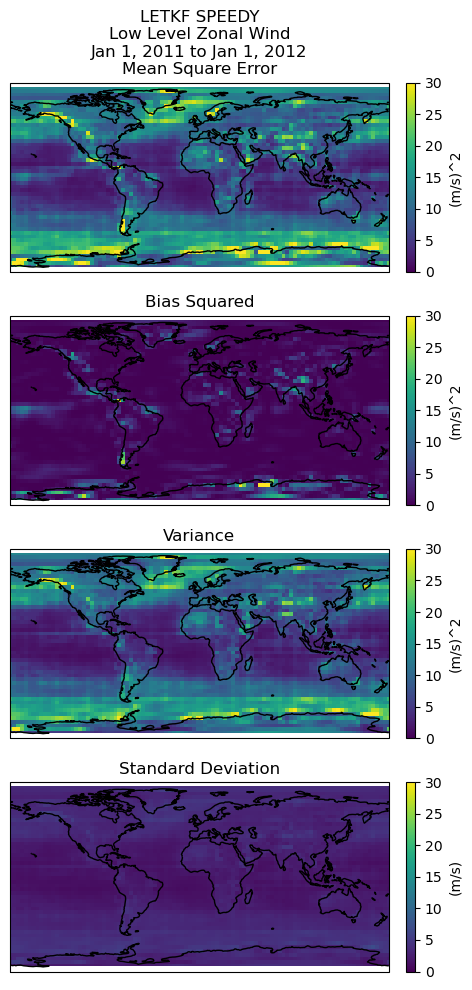

bias_hybrid_now_squared  [[2.15534783e-01 5.59279221e-01 9.17018543e-01 ... 3.84999202e-01
  9.52735161e-02 7.03982929e-03]
 [2.14319977e+00 1.68728464e+00 4.42939048e-01 ... 6.17969322e-01
  2.93908441e-01 1.06122567e+00]
 [6.27531332e+00 6.75511101e+00 8.15892649e+00 ... 3.40958673e+00
  3.41863300e+00 6.56996949e+00]
 ...
 [9.79201971e-01 6.95327351e-01 7.51801070e-01 ... 5.21007133e+00
  2.98743587e+00 1.57947373e+00]
 [4.12829639e+00 3.58234620e+00 3.16195082e+00 ... 4.56497775e+00
  4.69898736e+00 4.51761762e+00]
 [2.43924099e+00 2.18151536e+00 1.93252909e+00 ... 3.31370421e+00
  3.09935599e+00 2.77931234e+00]]


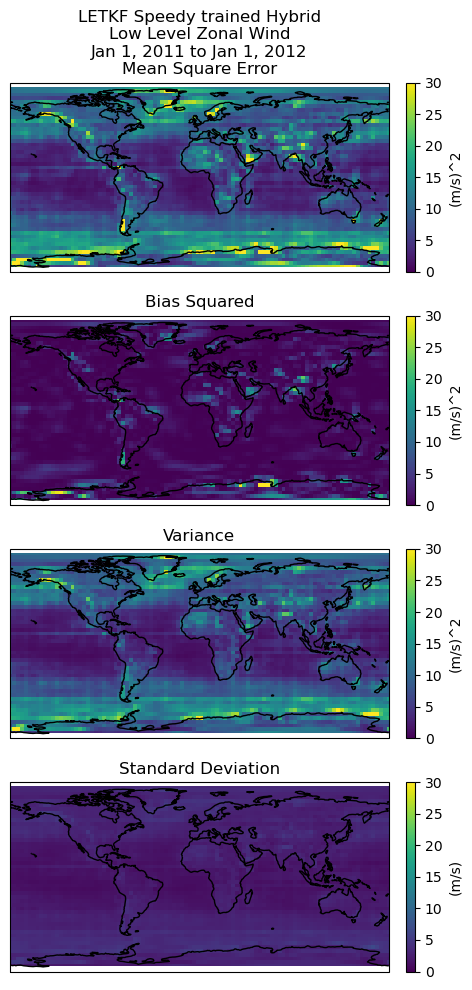

bias_hybrid_now_squared  [[6.51854432e-02 3.25811630e-02 2.66284742e-03 ... 3.70342682e-01
  2.74939315e-01 1.54336408e-01]
 [9.32956631e-02 4.91107707e-02 3.31414404e-02 ... 5.86491874e-02
  6.19426500e-02 6.36868373e-02]
 [4.85140049e-04 8.00257124e-03 1.46946664e-02 ... 2.62354847e-02
  3.44889051e-05 2.06174016e-02]
 ...
 [1.62845280e-01 1.52129662e-01 1.38384875e-01 ... 6.47390352e-02
  1.02691114e-01 1.29873888e-01]
 [1.12181901e-01 8.53448232e-02 1.99908301e-01 ... 5.03031914e-03
  2.38863571e-02 1.23867514e-02]
 [2.47373503e-02 4.08490991e-02 4.77901058e-02 ... 1.60440448e-01
  5.11710226e-02 5.19997703e-02]]


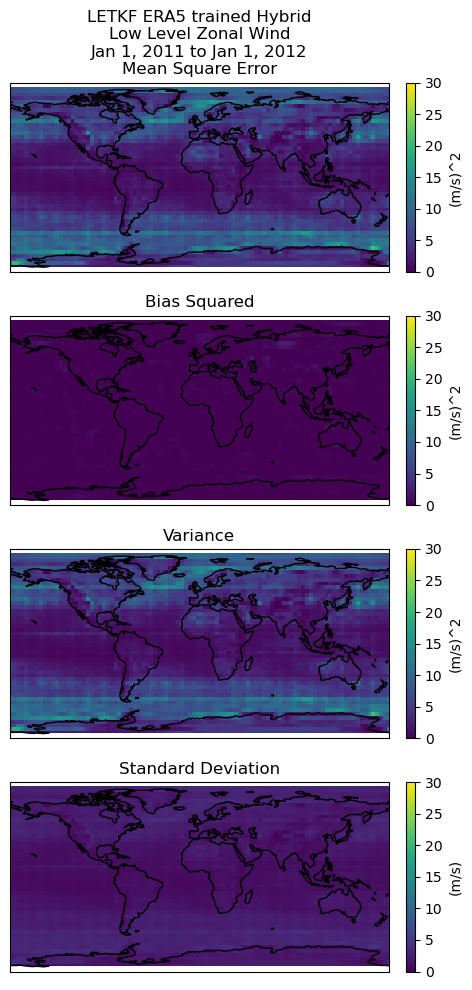

U-wind
you selected for variable = U-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'u' (lat: 48, lon: 96)>
array([[-3.401571, -3.149799, -2.964077, ..., -4.190509, -4.010161, -3.717222],
       [ 0.075176,  0.282802,  0.530989, ..., -0.792639, -0.490063, -0.127405],
       [ 1.163898,  1.68381 ,  1.878957, ...,  1.833153,  1.179469,  0.766434],
       ...,
       [ 9.285789,  9.030773,  9.154138, ..., 11.203781, 10.178337,  9.658768],
       [13.595819, 13.569829, 13.440147, ..., 13.274037, 13.408279, 13.538854],
       [12.691861, 12.492175, 12.20381 , ..., 12.68826 , 12.794279, 12.795476]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15

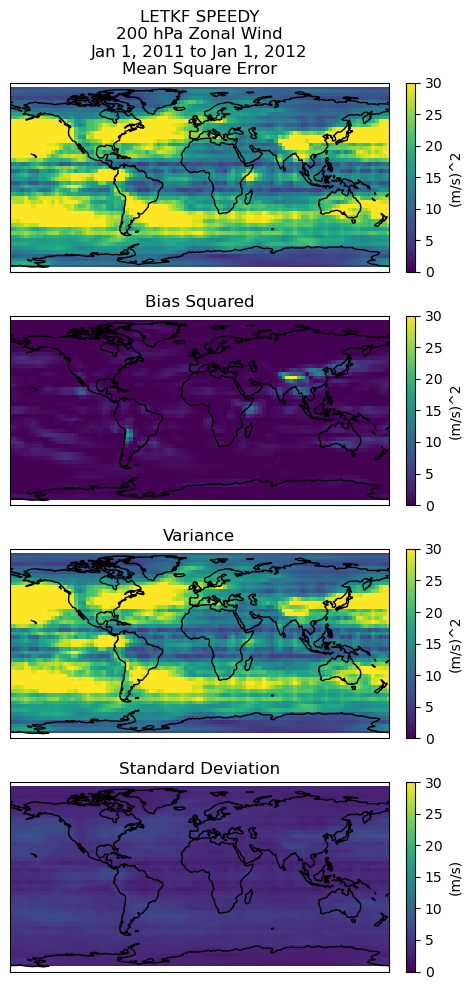

bias_hybrid_now_squared  [[1.41474260e-01 1.46750224e-01 1.56724877e-01 ... 1.20846376e-01
  1.28383740e-01 1.39621853e-01]
 [3.13463004e-02 3.26882268e-02 2.18810639e-02 ... 7.22572373e-02
  4.51933268e-02 3.36251583e-02]
 [1.83459835e-01 2.63072688e-01 3.76176775e-01 ... 3.04125778e-02
  6.02454441e-02 1.11005678e-01]
 ...
 [4.87303803e-01 3.91626981e-01 2.56371679e-01 ... 1.17639025e-01
  3.20274476e-01 4.40214625e-01]
 [1.93933566e-01 2.15052283e-01 1.95743385e-01 ... 2.13942431e-02
  8.00879308e-02 1.45751296e-01]
 [1.15866136e-03 2.39743498e-04 8.26731304e-04 ... 2.46478142e-02
  1.55525100e-02 4.62686817e-03]]


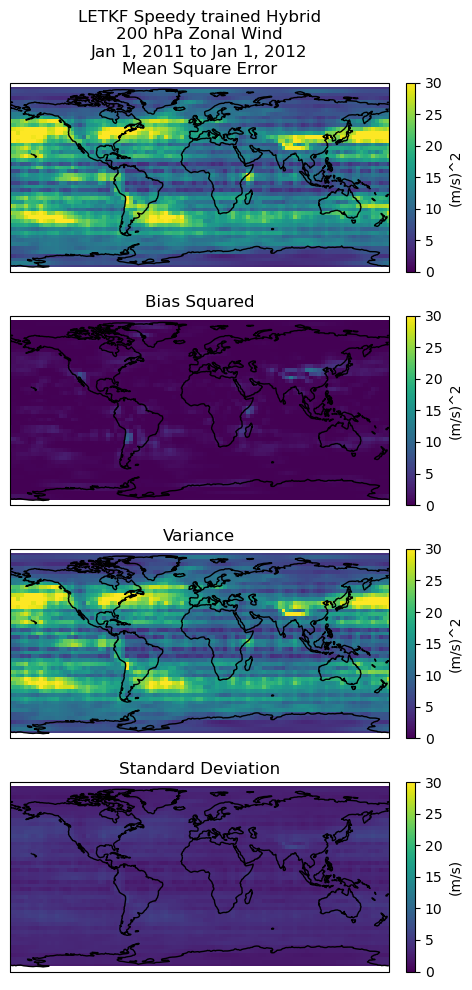

bias_hybrid_now_squared  [[1.31997008e-01 1.06652218e-01 7.61391857e-02 ... 1.08294441e-01
  1.47073444e-01 1.29379997e-01]
 [1.00645331e-01 4.83659511e-02 4.05508788e-02 ... 9.56602667e-02
  1.61072488e-01 1.32200033e-01]
 [2.18035367e-02 1.54194724e-02 6.47008159e-05 ... 6.12212404e-02
  4.60707256e-02 5.40469959e-02]
 ...
 [6.91436567e-02 1.11932803e-01 1.74962916e-01 ... 1.41154863e-02
  4.58412774e-02 8.55079509e-02]
 [5.15206947e-03 6.16792155e-06 1.59060886e-02 ... 1.30832380e-03
  8.20722999e-03 8.47051164e-05]
 [6.49510744e-02 5.60607142e-02 3.82846759e-02 ... 4.65292033e-02
  7.02455527e-02 6.82265030e-02]]


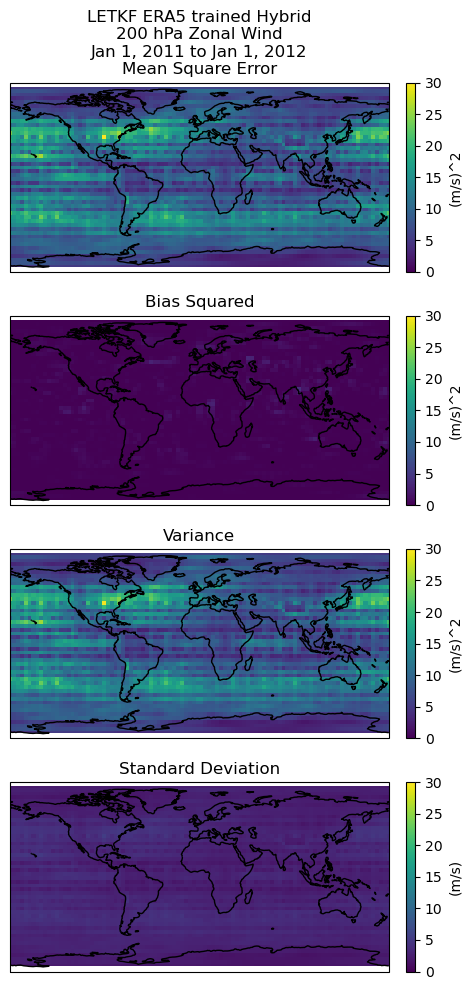

Temperature
you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 't' (lat: 48, lon: 96)>
array([[243.91919, 244.34344, 244.60558, ..., 243.1005 , 243.23799, 243.6439 ],
       [247.32155, 245.19379, 244.32245, ..., 250.50554, 249.80542, 248.75665],
       [252.27933, 250.99141, 249.50987, ..., 255.31985, 254.20512, 254.87671],
       ...,
       [255.67313, 255.96225, 255.5476 , ..., 254.24577, 253.52298, 254.37836],
       [249.59422, 249.69385, 249.42429, ..., 252.33673, 251.39975, 250.38976],
       [246.75928, 246.64218, 246.59608, ..., 247.54993, 247.30125, 247.0067 ]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7

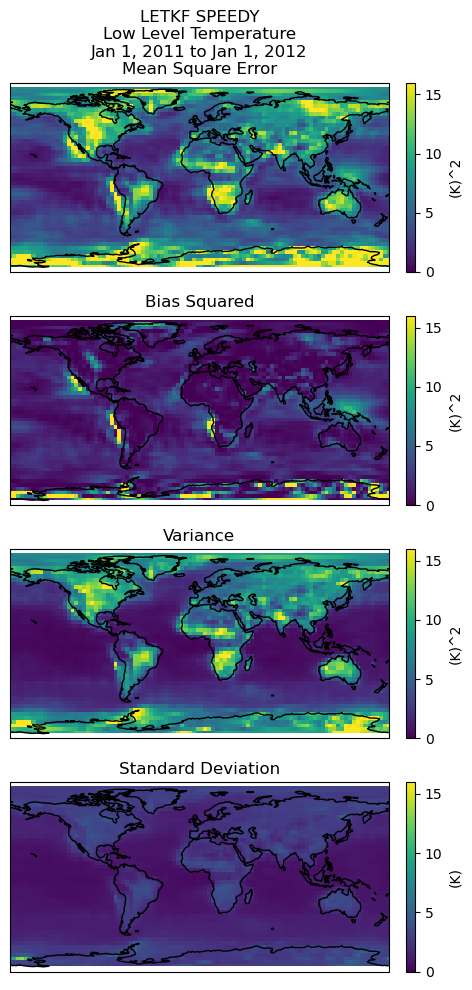

bias_hybrid_now_squared  [[4.14670711e+00 7.47376524e-01 2.10114376e-02 ... 7.37702834e+00
  9.86785014e+00 8.45174380e+00]
 [1.71244150e+01 2.65946223e+01 2.45544969e+01 ... 2.08645018e+01
  1.99050844e+01 1.87328010e+01]
 [4.76470962e+00 9.13574859e+00 1.22072783e+01 ... 3.90850647e-01
  1.31533163e+00 7.29278587e+00]
 ...
 [4.60769935e-02 9.74421228e-02 3.07271043e-01 ... 1.44875803e-01
  4.29742428e-01 6.05760758e-01]
 [8.30289739e-01 9.50555699e-01 9.86781451e-01 ... 4.61254618e-02
  1.00127453e-01 4.35429369e-01]
 [4.34602351e-01 4.78647172e-01 4.79711636e-01 ... 3.11859973e-01
  3.71659698e-01 4.04036330e-01]]


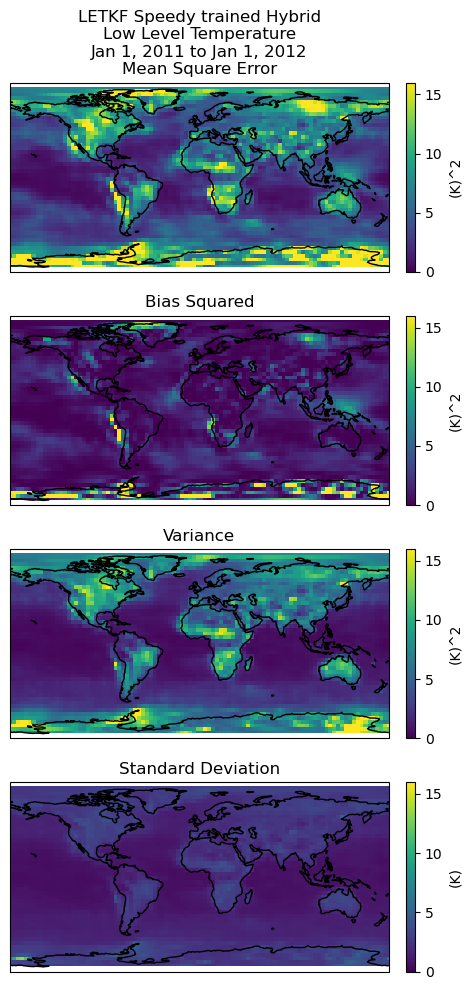

bias_hybrid_now_squared  [[1.86042506e-01 4.09331515e-02 4.40306913e-06 ... 1.08345311e+00
  9.47056191e-01 5.74966348e-01]
 [3.48791724e-01 4.11009399e-01 1.64451616e-01 ... 2.38376575e-01
  2.30119979e-01 2.16378154e-01]
 [6.04857799e-02 2.23918450e-01 2.57074850e-01 ... 9.27220483e-03
  4.90283327e-03 8.94176356e-02]
 ...
 [3.25760685e-04 6.84708533e-03 2.56244697e-02 ... 4.13307855e-02
  6.62858522e-02 1.39635267e-02]
 [1.17840310e-04 1.80182506e-02 2.71179425e-02 ... 1.37587508e-01
  7.15459740e-02 1.54127245e-02]
 [6.73423781e-02 3.71952789e-02 3.92726966e-03 ... 2.31578416e-01
  1.59095722e-01 1.16861440e-01]]


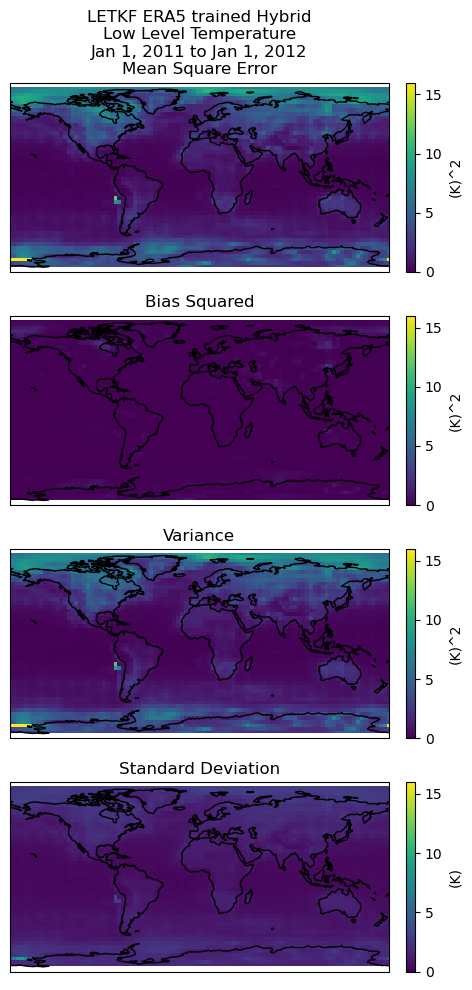

Temperature
you selected for variable = Temperature
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 't' (lat: 48, lon: 96)>
array([[216.45035, 216.37367, 216.28598, ..., 216.91692, 216.7007 , 216.54562],
       [215.32732, 215.11552, 215.076  , ..., 215.84917, 215.64197, 215.4856 ],
       [214.1805 , 213.25159, 212.40642, ..., 214.9086 , 215.03761, 214.81277],
       ...,
       [209.17964, 208.56062, 208.17064, ..., 211.7201 , 210.72348, 209.85826],
       [209.86389, 209.54816, 209.34178, ..., 211.3948 , 210.77983, 210.25793],
       [212.41737, 212.36574, 212.33722, ..., 212.64444, 212.56056, 212.48375]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7.

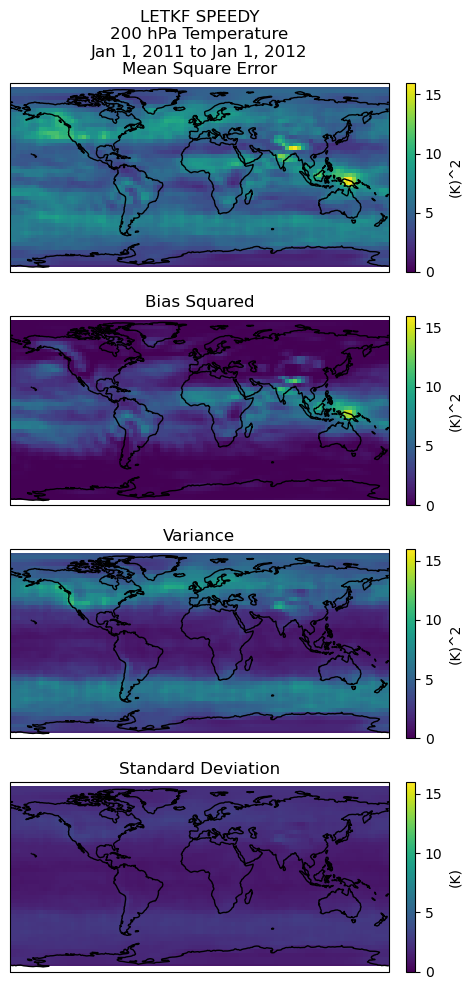

bias_hybrid_now_squared  [[4.25866129e-05 5.15356751e-05 1.45203822e-04 ... 2.54951700e-04
  8.78019079e-05 2.82171136e-06]
 [4.09395712e-02 6.78211663e-02 1.08931143e-01 ... 5.54125701e-03
  1.39137977e-02 2.42605743e-02]
 [8.44353441e-04 1.26701617e-02 4.15388360e-02 ... 1.63352460e-02
  9.20527831e-03 1.39630777e-03]
 ...
 [9.26241301e-01 8.91931121e-01 7.75127354e-01 ... 4.34670527e-01
  6.53256472e-01 8.38130411e-01]
 [6.98808576e-01 7.03026438e-01 6.82361018e-01 ... 4.47231221e-01
  5.58279276e-01 6.42696171e-01]
 [3.79266769e-01 3.68554664e-01 3.63355968e-01 ... 3.61094598e-01
  3.76014454e-01 3.74928221e-01]]


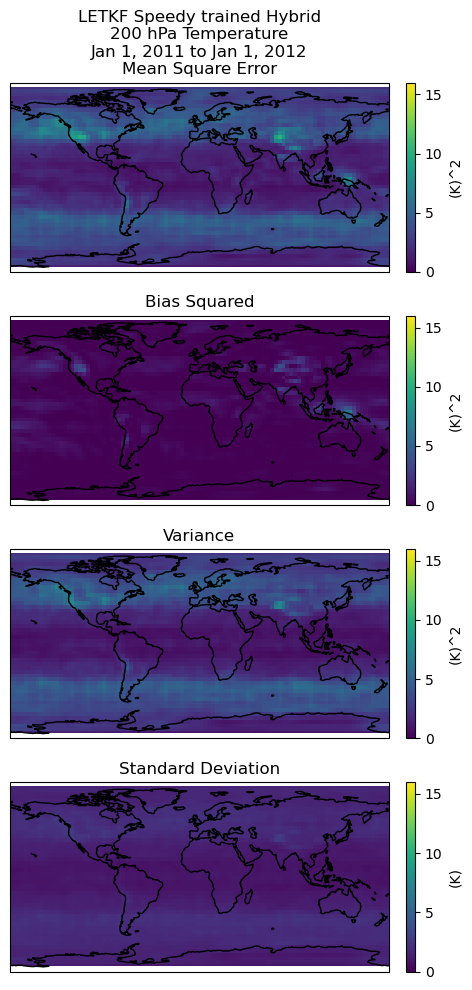

bias_hybrid_now_squared  [[3.88978529e-03 3.81652811e-03 4.49027355e-03 ... 8.10627543e-03
  4.55167155e-03 4.18730925e-03]
 [5.37032653e-02 4.35701432e-02 3.54042680e-02 ... 7.13599748e-02
  5.51322295e-02 4.87901400e-02]
 [1.07990278e-03 2.78809366e-03 3.20573898e-03 ... 1.95281350e-02
  2.20239395e-03 4.73802182e-05]
 ...
 [3.37050498e-02 6.36098925e-02 7.84762154e-02 ... 2.69964592e-02
  6.38446727e-03 4.78454448e-04]
 [5.35769475e-02 5.45230240e-02 5.84466691e-02 ... 2.19897892e-02
  3.32083503e-02 3.14481321e-02]
 [1.52064989e-01 1.39834829e-01 1.37154511e-01 ... 9.73697737e-02
  1.21933213e-01 1.12033513e-01]]


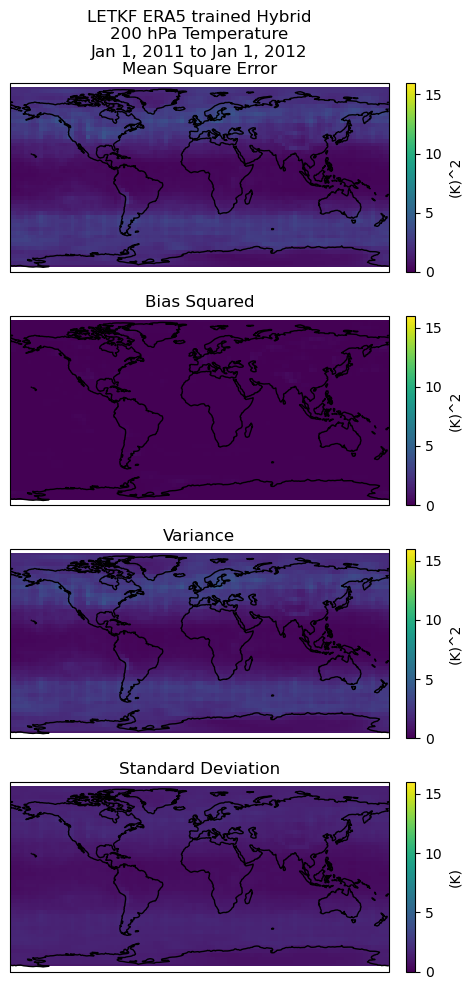

V-wind
you selected for variable = V-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'v' (lat: 48, lon: 96)>
array([[-4.926433, -5.123497, -5.422033, ..., -5.048776, -4.99351 , -4.890265],
       [-6.497398, -7.248275, -6.6601  , ..., -3.260862, -4.048383, -5.012127],
       [-4.080621, -3.453741, -3.170013, ..., -5.964931, -4.062701, -2.218242],
       ...,
       [-5.09833 , -4.661013, -3.610479, ..., -0.98033 , -2.856604, -4.333219],
       [ 2.110096,  2.511278,  2.512395, ...,  4.581005,  3.865231,  2.902747],
       [ 3.181213,  3.054303,  2.648486, ...,  3.096857,  3.170759,  3.16026 ]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7.5 11.25 1

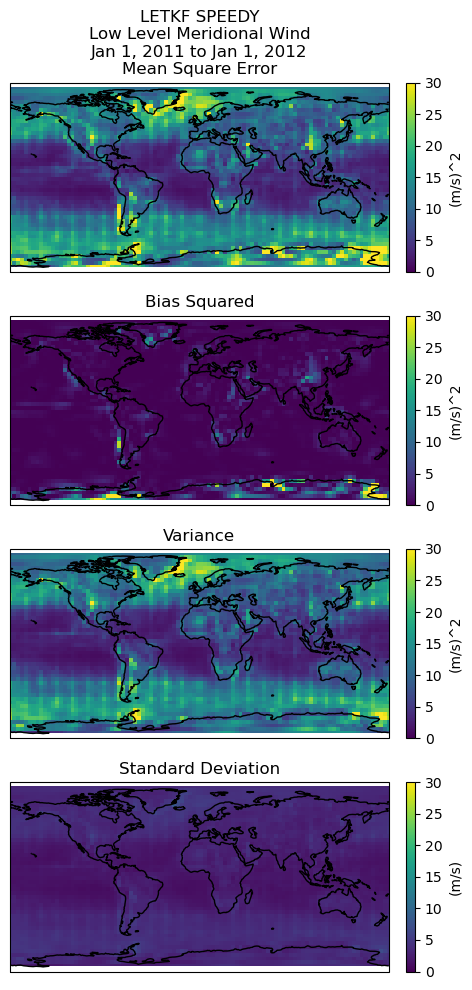

bias_hybrid_now_squared  [[8.62251609e-02 3.89303884e-01 5.60485432e-01 ... 9.59561067e-01
  3.11519417e-01 1.44450921e-02]
 [2.60111876e+00 1.65809399e+00 1.91142382e+00 ... 1.33877405e+01
  1.05531722e+01 5.81997457e+00]
 [2.33848790e+00 3.91989022e+00 2.48200288e+00 ... 1.72963663e+00
  4.73348433e+00 5.82742534e+00]
 ...
 [2.59225581e-01 2.79715905e-01 4.98763758e-01 ... 3.50084357e-02
  1.25702209e-03 1.04181298e-01]
 [9.19585622e-01 7.60541860e-01 5.90918015e-01 ... 4.27804824e-02
  3.77716259e-01 7.44122008e-01]
 [5.34158358e-01 4.88994239e-01 4.49116368e-01 ... 4.98064733e-01
  5.44353434e-01 5.54854911e-01]]


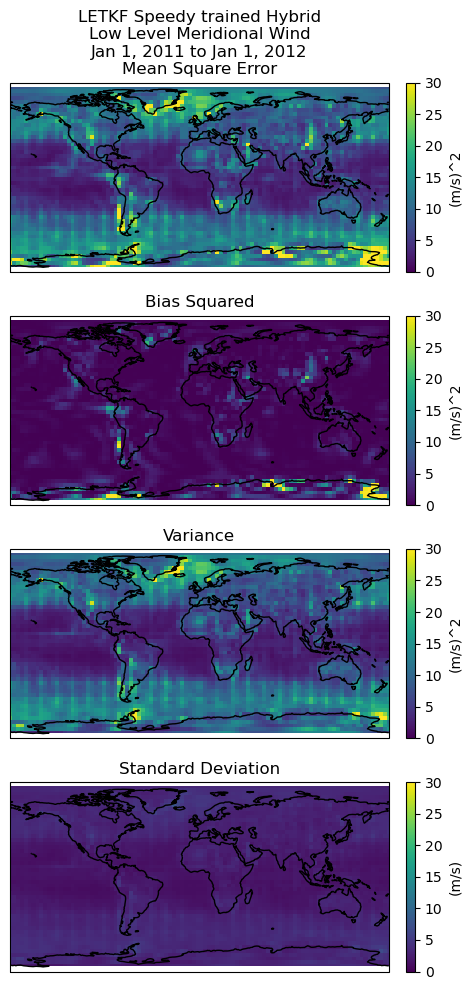

bias_hybrid_now_squared  [[0.04156445 0.02295569 0.04304455 ... 0.28775023 0.17351911 0.10423048]
 [0.16250053 0.14528175 0.08685404 ... 0.00859704 0.03450521 0.083342  ]
 [0.54484396 0.34148273 0.28968306 ... 0.28114873 0.33014707 0.35805246]
 ...
 [0.31617408 0.35550166 0.45665148 ... 1.1127757  0.53823073 0.41067684]
 [0.00871985 0.01489416 0.07913359 ... 0.02670519 0.04158403 0.00724887]
 [0.2153104  0.1971105  0.1817153  ... 0.41153533 0.38529959 0.35880757]]


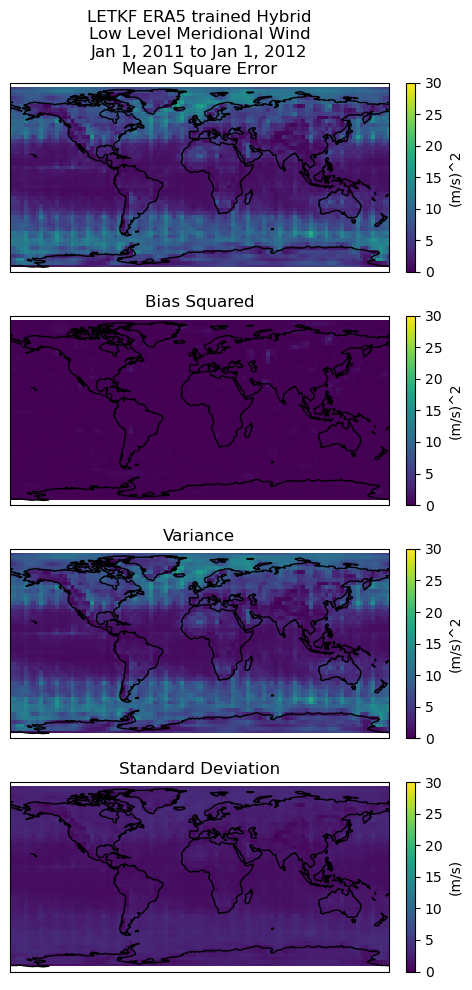

V-wind
you selected for variable = V-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'v' (lat: 48, lon: 96)>
array([[-0.697076, -1.02728 , -1.367197, ...,  0.380313, -0.032907, -0.379555],
       [-2.613001, -2.724056, -3.062883, ..., -2.193759, -2.53862 , -2.621226],
       [-3.114785, -3.26048 , -3.216159, ..., -1.45761 , -1.866138, -2.432457],
       ...,
       [-1.027906, -2.017979, -3.286185, ...,  1.457689,  0.668608, -0.181009],
       [-0.867295, -2.442718, -4.11816 , ...,  3.077409,  1.919865,  0.574095],
       [-3.854692, -4.975684, -6.080714, ..., -0.61546 , -1.658302, -2.738505]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15

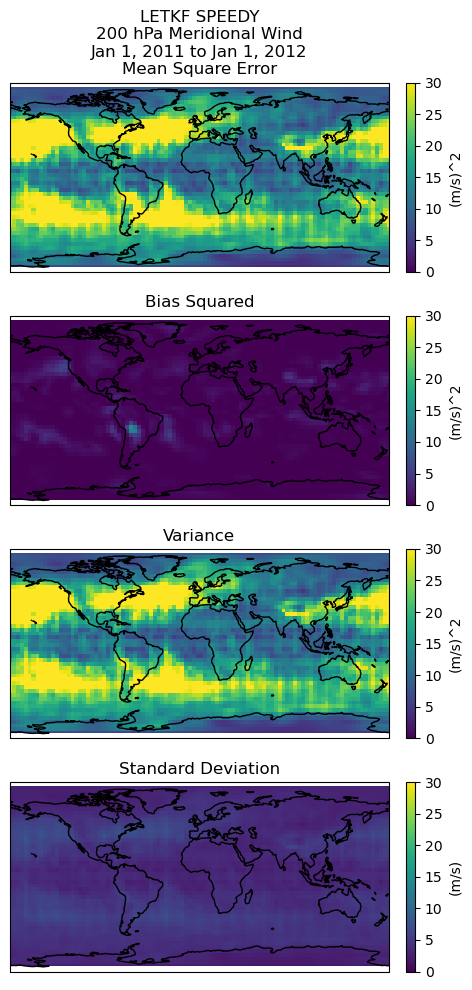

bias_hybrid_now_squared  [[0.04251999 0.03231648 0.0227857  ... 0.06047362 0.05943685 0.05047344]
 [0.02292497 0.03447374 0.04102422 ... 0.00720795 0.01042664 0.01657734]
 [0.17361201 0.16291637 0.11577154 ... 0.12278787 0.14430052 0.1717155 ]
 ...
 [0.00253636 0.04581335 0.14152366 ... 1.25541536 0.60923112 0.16562644]
 [0.29601502 0.16668262 0.08650292 ... 0.92408834 0.69865735 0.4835842 ]
 [0.40108398 0.38194657 0.36555682 ... 0.42129202 0.43212055 0.42663858]]


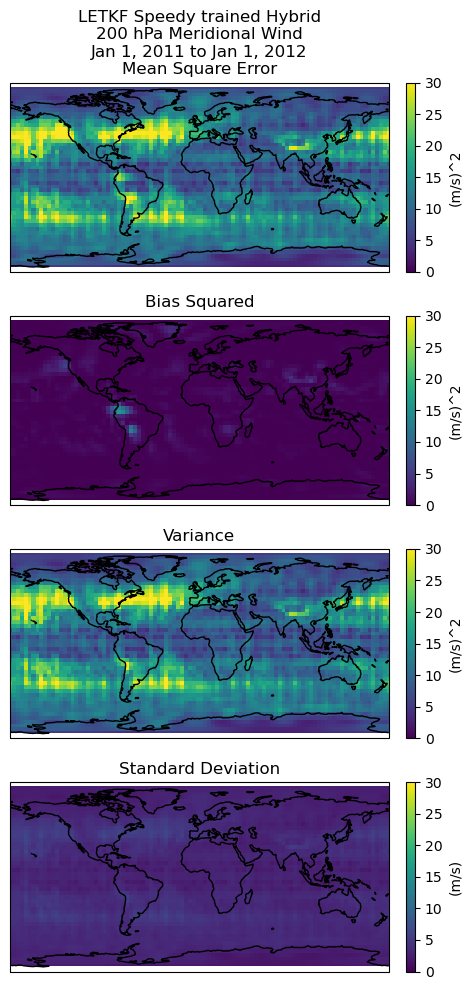

bias_hybrid_now_squared  [[1.95254552e-01 2.26274346e-01 1.48963515e-01 ... 1.41262425e-01
  1.59262350e-01 1.99100539e-01]
 [3.12890164e-01 3.33752736e-01 2.93567320e-01 ... 1.36286811e-01
  1.86618442e-01 2.52132861e-01]
 [5.70957844e-01 5.86127625e-01 5.23322858e-01 ... 2.48195333e-01
  3.81390435e-01 4.34395514e-01]
 ...
 [9.37796173e-01 7.22751928e-01 3.38130550e-01 ... 1.25414266e+00
  1.49223097e+00 1.49150909e+00]
 [1.73294412e-01 1.13569395e-01 4.81395180e-02 ... 1.17824830e-01
  1.91998838e-01 1.67654064e-01]
 [4.23262302e-04 4.88925872e-04 1.01726751e-02 ... 1.43452760e-02
  9.72018939e-03 8.71443341e-03]]


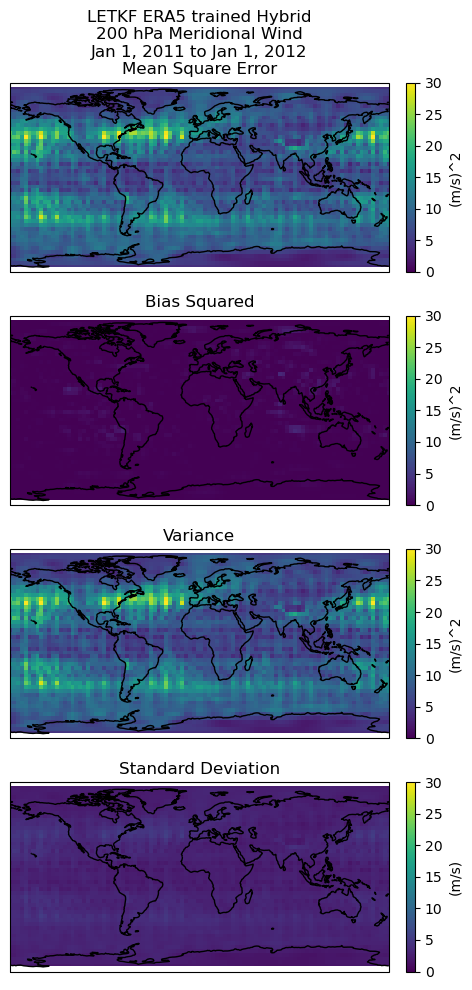

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'q' (lat: 48, lon: 96)>
array([[2.966980e-04, 2.828905e-04, 2.758084e-04, ..., 3.296966e-04,
        3.266433e-04, 3.165804e-04],
       [3.870659e-04, 3.739973e-04, 3.403371e-04, ..., 4.106265e-04,
        3.920982e-04, 3.865915e-04],
       [3.888344e-04, 3.337094e-04, 3.393310e-04, ..., 4.783382e-04,
        4.429635e-04, 4.425438e-04],
       ...,
       [8.653777e-04, 1.099216e-03, 1.048577e-03, ..., 5.574755e-05,
        2.077886e-04, 5.327183e-04],
       [2.481168e-04, 1.197066e-04, 1.238376e-04, ..., 2.109703e-04,
        1.514017e-04, 1.731702e-04],
       [3.170417e-05, 2.850567e-05, 2.929563e-05,

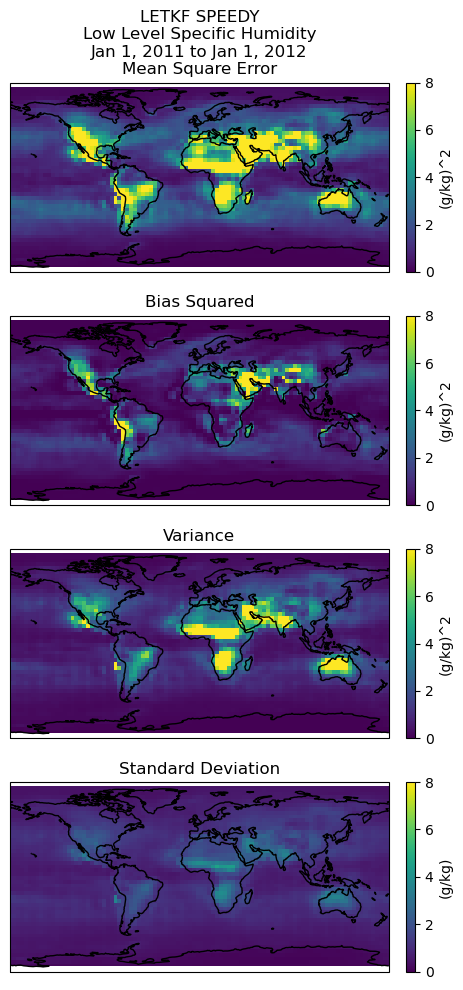

bias_hybrid_now_squared  [[0.0200693  0.02110696 0.02198446 ... 0.02363454 0.02108527 0.01992026]
 [0.01185578 0.00728943 0.00384993 ... 0.0151023  0.01333963 0.01262123]
 [0.03832762 0.0316865  0.02731701 ... 0.05565803 0.04810508 0.04873033]
 ...
 [0.22142895 0.23319008 0.20908728 ... 0.12967019 0.13750328 0.17861868]
 [0.1734668  0.16666809 0.15357021 ... 0.17807274 0.18436969 0.18051972]
 [0.06474797 0.06293964 0.06112128 ... 0.0707919  0.06888319 0.06711432]]


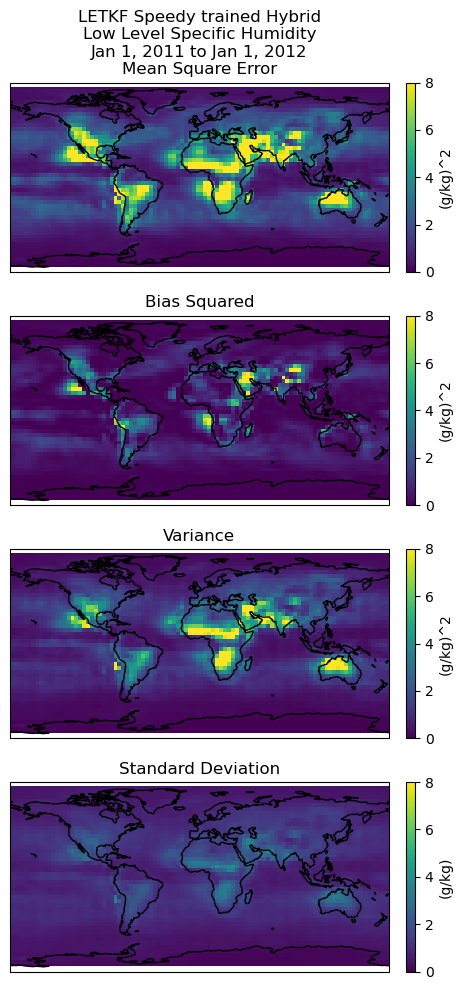

bias_hybrid_now_squared  [[2.30312994e-07 1.91099843e-06 2.98837733e-05 ... 4.45604280e-05
  2.82883258e-05 1.96977728e-05]
 [8.77489357e-07 1.30513933e-08 3.47458628e-06 ... 1.11879807e-05
  1.27214587e-05 9.49576599e-06]
 [6.85595147e-05 5.50955575e-05 1.76943853e-05 ... 1.92958649e-04
  7.01326464e-05 8.92439688e-05]
 ...
 [5.67527736e-04 5.68364464e-04 1.77050834e-04 ... 4.92554609e-03
  2.89051459e-03 1.34248604e-03]
 [2.84972057e-03 2.80922031e-03 4.68840931e-03 ... 1.23595872e-03
  1.77368156e-03 2.32756620e-03]
 [5.55361648e-03 6.59881767e-03 8.03584602e-03 ... 2.17360587e-03
  3.41155749e-03 4.35876248e-03]]


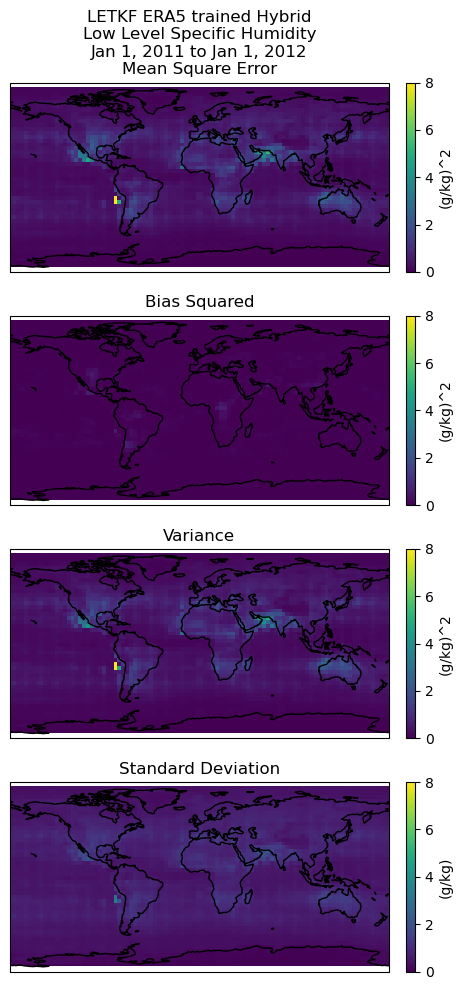

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'q' (lat: 48, lon: 96)>
array([[1.831847e-06, 1.842766e-06, 1.831794e-06, ..., 1.870530e-06,
        1.858924e-06, 1.852949e-06],
       [1.981276e-06, 1.929611e-06, 1.916301e-06, ..., 1.974500e-06,
        1.968137e-06, 1.965899e-06],
       [2.008020e-06, 1.939521e-06, 1.934962e-06, ..., 2.131943e-06,
        2.171485e-06, 2.111867e-06],
       ...,
       [8.954502e-06, 9.602112e-06, 9.732233e-06, ..., 6.424174e-06,
        7.469660e-06, 8.358477e-06],
       [8.497247e-06, 8.791937e-06, 8.961232e-06, ..., 7.344539e-06,
        7.817524e-06, 8.212116e-06],
       [8.215678e-06, 8.249554e-06, 8.311014e-06, 

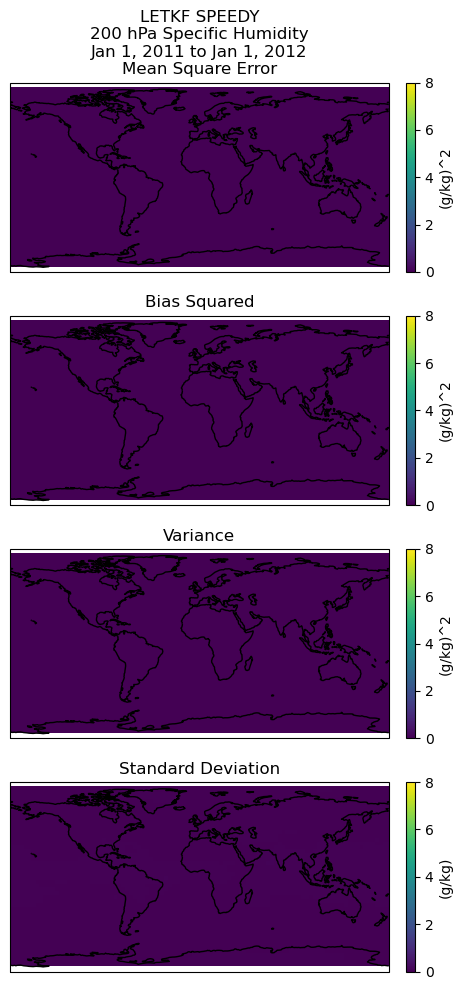

bias_hybrid_now_squared  [[0.00069958 0.00070649 0.00071291 ... 0.00068039 0.00068643 0.00069289]
 [0.00072137 0.00074242 0.00076128 ... 0.00065723 0.0006778  0.00069965]
 [0.00076197 0.00079571 0.0008258  ... 0.0006594  0.00069305 0.00072745]
 ...
 [0.0017184  0.00167158 0.00163423 ... 0.00190798 0.00184166 0.001776  ]
 [0.00157271 0.0015572  0.00154324 ... 0.00162365 0.00160712 0.00158946]
 [0.00141028 0.00141131 0.00141239 ... 0.0014071  0.0014083  0.00140925]]


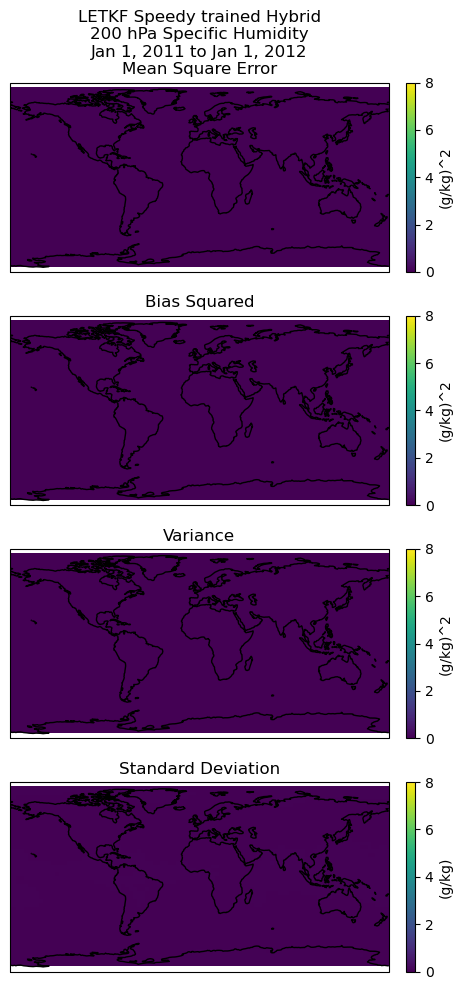

bias_hybrid_now_squared  [[5.02570920e-09 5.29745734e-09 4.99048031e-09 ... 5.54968687e-09
  5.57784197e-09 5.42139395e-09]
 [3.29129265e-09 4.32571868e-09 5.07286173e-09 ... 3.57090728e-09
  2.64080027e-09 2.34277925e-09]
 [4.44761790e-09 5.91938618e-09 6.79128724e-09 ... 4.58421121e-09
  3.60722229e-09 3.51586255e-09]
 ...
 [3.24239062e-07 5.11515314e-07 7.45177422e-07 ... 2.09937025e-08
  8.43821390e-08 1.73617204e-07]
 [5.84535568e-07 6.37860620e-07 7.09234486e-07 ... 1.83422787e-07
  3.39063434e-07 3.96672782e-07]
 [6.91450794e-07 6.86637112e-07 7.66512405e-07 ... 4.27302691e-07
  5.69268014e-07 5.68821761e-07]]


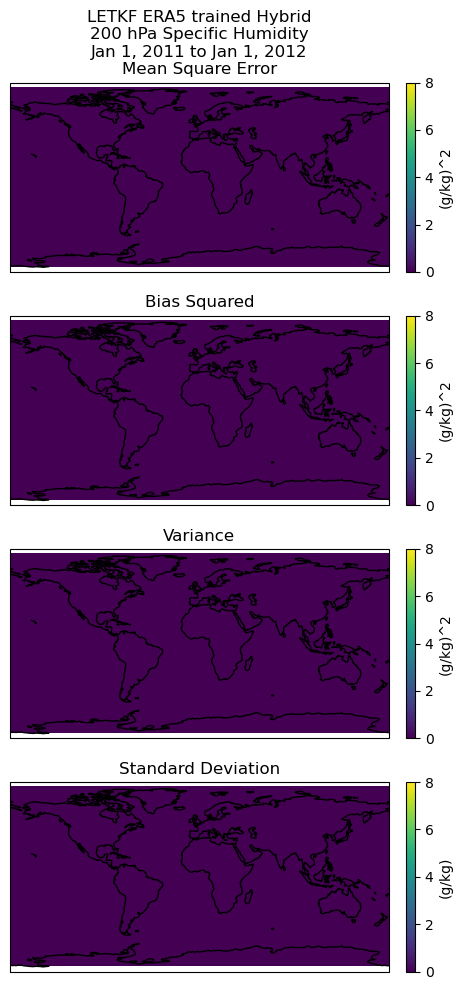

In [35]:
## works!
## need to change file and dates in function above before running this cell

## LOOP THROUGH FUNCTION
# FUNCTION INPUTS
level_list_speedy = [.95,.2]
variable_list_speedy = ['u','t','v','q']

# for level in level_list_speedy:

for variable in variable_list_speedy:
    for level in level_list_speedy:
        rmse_time_series_plot_and_maps(level,variable)

IndexError: index 2 is out of bounds for GridSpec with size 2

/h/dylanelliott/anaconda3/envs/py_env_plot/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


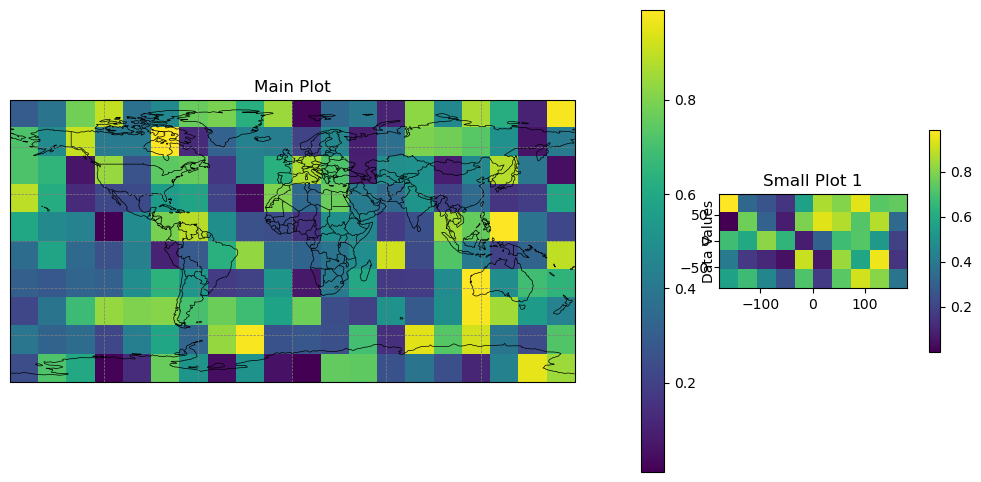

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

# Create sample data for the main and two smaller plots
data_main = np.random.rand(10, 20)
data_small1 = np.random.rand(5, 10)
data_small2 = np.random.rand(5, 10)

# Define the extent of your data (lon, lat)
lon_main = np.linspace(-180, 180, 20)
lat_main = np.linspace(-90, 90, 10)

lon_small = np.linspace(-180, 180, 10)
lat_small = np.linspace(-90, 90, 5)

# Create a Cartopy Lambert Conformal projection
projection = ccrs.PlateCarree()
# Create a figure and a 1x2 grid for subplots with the specified projection
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.1)

# Main plot
ax_main = plt.subplot(gs[0], projection=projection)
img_main = ax_main.imshow(data_main, extent=(lon_main.min(), lon_main.max(), lat_main.min(), lat_main.max()), origin='lower', cmap='viridis', transform=projection)
ax_main.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_main.add_feature(cfeature.BORDERS, linewidth=0.5)
ax_main.gridlines(color='gray', linestyle='--', linewidth=0.5)
cbar_main = plt.colorbar(img_main, ax=ax_main, orientation='vertical', fraction=0.05, pad=0.1)
cbar_main.set_label('Data Values')
ax_main.set_title('Main Plot')

# Smaller subplot 1
ax_small1 = plt.subplot(gs[1])
img_small1 = ax_small1.imshow(data_small1, extent=(lon_small.min(), lon_small.max(), lat_small.min(), lat_small.max()), origin='lower', cmap='viridis')
ax_small1.set_title('Small Plot 1')
plt.colorbar(img_small1, ax=ax_small1, orientation='vertical', fraction=0.05, pad=0.1)

# Smaller subplot 2
ax_small2 = plt.subplot(gs[2])
img_small2 = ax_small2.imshow(data_small2, extent=(lon_small.min(), lon_small.max(), lat_small.min(), lat_small.max()), origin='lower', cmap='viridis')
ax_small2.set_title('Small Plot 2')
plt.colorbar(img_small2, ax=ax_small2, orientation='vertical', fraction=0.05, pad=0.1)

# Set overall title
plt.suptitle('Array Plots with Cartopy and imshow')

# Show the plot
plt.show()

U-wind
you selected for variable = U-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = U-wind
at level = 0.95
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


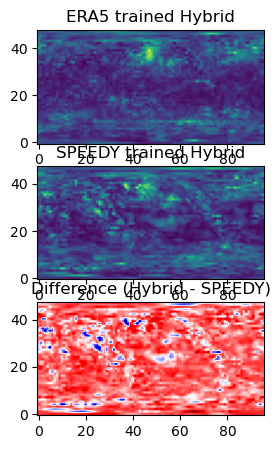

Temperature
you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Temperature
at level = 0.95
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


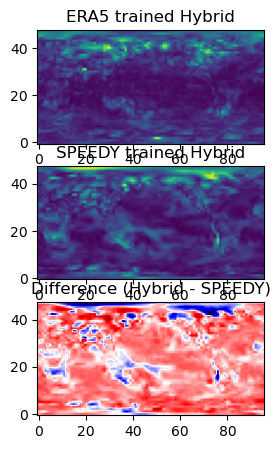

V-wind
you selected for variable = V-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = V-wind
at level = 0.95
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


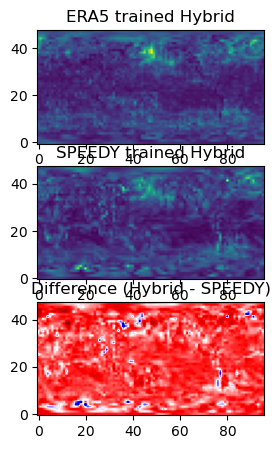

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Specific_Humidity
at level = 0.95
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


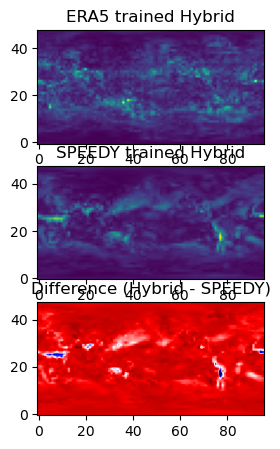

U-wind
you selected for variable = U-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = U-wind
at level = 0.2
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


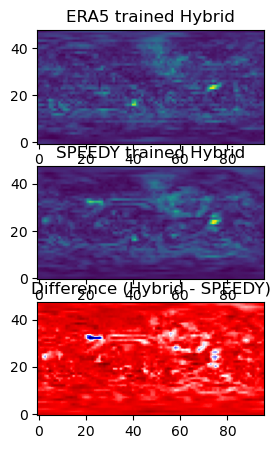

Temperature
you selected for variable = Temperature
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Temperature
at level = 0.2
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


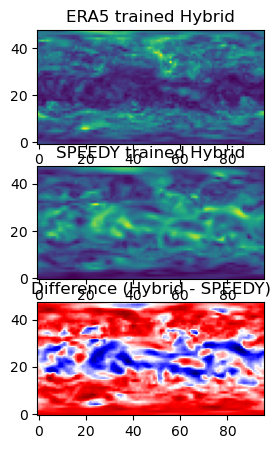

V-wind
you selected for variable = V-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = V-wind
at level = 0.2
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


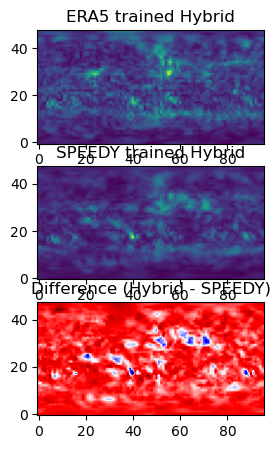

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (40, 48, 96)
hybrid shape =  (40, 48, 96)
the smallest length is 40
(40, 48, 96)
(40, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Specific_Humidity
at level = 0.2
MAKING zeros arrays..
Done with analysis.
Now plotting and meshing...


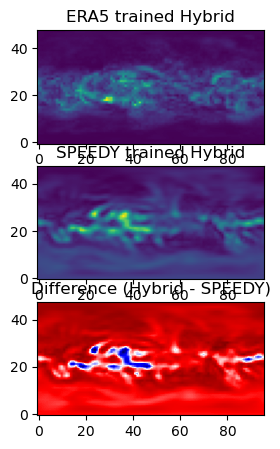

In [5]:
## works!
## need to change file and dates in function above before running this cell

## LOOP THROUGH FUNCTION
# FUNCTION INPUTS
level_list_speedy = [.95,.2]
variable_list_speedy = ['u','t','v','q']

for level in level_list_speedy:
    for variable in variable_list_speedy:
        rmse_time_series_plot_and_maps(level,variable)



In [6]:

#     diff = averaged_error - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     ''' Multiply averaged_error by 1000 for spec_humid only'''

#     if var_era == 'Temperature':
#         units='(K)'
#     if var_era == 'Specific_Humidity':
#         units='(g/kg)'
#     if var_era == 'V-wind':
#         units='(m/s)'
#     if var_era == 'U-wind':
#         units='(m/s)'
#     print(units)
#     if level == .95:
#         title_level = 'Low Level '
#     if level == .2:
#         title_level = '200 hPa '

#     if var_era == 'Specific_Humidity':
#         title_var_era = 'Specific Humidity'
#     if var_era == 'V-wind':
#         title_var_era = "Meridional Wind"
#     if var_era == 'Temperature':
#         title_var_era = 'Temperature'
#     if var_era == 'U-wind':
#         title_var_era = 'Zonal Wind'
#     print(title_var_era)

#     if level == .95 and var_era == 'Temperature':
#         adapted_range = np.arange(0,5.05,.05)
#         adapted_difference_range = np.arange(-5,5,.05)

#     if level == .2 and var_era == 'Temperature':
# #         adapted_range = np.arange(0,.1,.001)
# #         adapted_difference_range = np.arange(-.05,.05,.001)
#         adapted_range = np.arange(0,5.05,.05)
#         adapted_difference_range = np.arange(-5,5,.05)

#     if level == .95 and var_era == 'Specific_Humidity':
#         adapted_range = np.arange(0,3,.05)
#         adapted_difference_range = np.arange(-2,2,.001)

#     if level == .2 and var_era == 'Specific_Humidity':
#         adapted_range = np.arange(0,.1,.001)
#         adapted_difference_range = np.arange(-.05,.05,.001)

#     if level == .2 and var_era == 'V-wind':
#         adapted_range = np.arange(0,10.05,.05)
#         adapted_difference_range = np.arange(-2,2.1,.05)
#     if level == .95 and var_era == 'V-wind':
#         adapted_range = np.arange(0,10.05,.05)
#         adapted_difference_range = np.arange(-2,2.1,.05)
#     if level == .95 and var_era == 'U-wind':
#         adapted_range = np.arange(0,10.05,.05)
#         adapted_difference_range = np.arange(-2,2.1,.05)
#     if level == .2 and var_era == 'U-wind':
#         adapted_range = np.arange(0,10.05,.05)
#         adapted_difference_range = np.arange(-2,2.1,.05)
    
#     fs = 16
    
#     ### ADAPT TO 2 small on top 1 big plot below
#     # PLOT 1

#     fig = plt.figure(figsize=(10,8))
    
#     fig.suptitle('LETKF Analysis Error\n' + title_level +  title_var_era + '\nJan 1, 2011 to Jan 1, 2012',fontsize=fs)

#     gs = fig.add_gridspec(2,2, width_ratios=[1, 1], height_ratios=[1.3, 3])
#     ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
#     ''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
# #     ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
#     ax1.coastlines()
    
#     # Mulitply 1000 for spec humid
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
#     else: 
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
        
#     cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)

# #     plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
#     ax1.set_title('ERA5 trained Hybrid',fontsize=fs) #1.3

#     '''ax2 ===>  makes plot of speedy letkf analysis error '''
# #     ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
#     ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
#     ax2.coastlines()
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
# #     plt.colorbar(cf,label=units,fraction=0.02, pad=0.04)
#     colorbar = plt.colorbar(cf,fraction=0.02, pad=0.04)
#     colorbar
#     colorbar.ax.tick_params(labelsize = 14)
#     colorbar.set_label(units,fontsize=14)
#     ax2.set_title('SPEEDY',fontsize=fs)

#     diff = averaged_error - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     '''ax3 ==> Makes map of difference of hybrid and speedy '''
#     ax3 = fig.add_subplot(gs[1, :],projection=ccrs.PlateCarree())
# #     ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
#     ax3.coastlines()
#     ax3.set_title('Difference (Hybrid - SPEEDY)',fontsize=fs)
    
#     # high_level_difference_range = np.arange(-.05,.05,.001)
#     # low_level_difference_range = np.arange(-5,5,.05)

#     cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=adapted_difference_range,extend='both',cmap='seismic')
#     colorbar2 = plt.colorbar(cf,fraction=0.02, pad=0.04)
#     colorbar2
#     colorbar2.ax.tick_params(labelsize= 14)
#     colorbar2.set_label(units,fontsize = 14)
#     plt.tight_layout(pad=1.0)
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
    
#     # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
#     filenameera5 = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}_ERA5.png"
#     print(filenameera5)
#     # Save the figure with the generated filename
#     plt.savefig('Maps_Speedy_trained_Hybrid_ERA5_trained_Hybrid/' + filenameera5,dpi=1200)
#     plt.show()
    
# #     #####################################
#     print('looping through hybrid 1.3,1.3 ..')
#     for i in range(length):
# #         anal_error_troy[i,:,:] = ds_anal_troy[i,:,:] - temp_500_nature[i,:,:]
# #         anal_rmse_troy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_anal_troy[i,:,:],lats)
#         anal_mean_error_hybrid_1_3_1_3[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
#         anal_mean_rmse_hybrid_1_3_1_3[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:],lats)
# #         global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
        
# ### 2nd MAP

#     averaged_error = np.average(abs(anal_mean_error_hybrid_1_3_1_3[24::,:,:]),axis=0)
#     averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)


#     fig = plt.figure(figsize=(10,8))

#     fig.suptitle('LETKF Analysis Error\n' + title_level +  title_var_era + '\nJan 1, 2011 to Jan 1, 2012',fontsize =fs)

#     gs = fig.add_gridspec(2,2, width_ratios=[1, 1], height_ratios=[1.3, 3])
#     ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
#     ''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
# #     ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
#     ax1.coastlines()
    
#     # Mulitply 1000 for spec humid
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
#     else: 
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
        
#     cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)

# #     plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
#     ax1.set_title('Speedy trained Hybrid',fontsize =fs) #1.3

#     '''ax2 ===>  makes plot of speedy letkf analysis error '''
# #     ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
#     ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
#     ax2.coastlines()
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
#     colorbar = plt.colorbar(cf,fraction=0.02, pad=0.04)
#     colorbar
#     colorbar.ax.tick_params(labelsize = 14)
#     colorbar.set_label(units,fontsize=14)
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
#     ax2.set_title('SPEEDY',fontsize =fs)

#     diff = averaged_error - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     '''ax3 ==> Makes map of difference of hybrid and speedy '''
#     ax3 = fig.add_subplot(gs[1, :],projection=ccrs.PlateCarree())
# #     ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
#     ax3.coastlines()
#     ax3.set_title('Difference (Hybrid - SPEEDY)',fontsize =fs)
    
#     # high_level_difference_range = np.arange(-.05,.05,.001)
#     # low_level_difference_range = np.arange(-5,5,.05)

#     cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=adapted_difference_range,extend='both',cmap='seismic')
#     colorbar2 = plt.colorbar(cf,fraction=0.02, pad=0.04)
#     colorbar2 
#     colorbar2.ax.tick_params(labelsize = 14)
#     colorbar2.set_label(units,fontsize=14)
    
#     plt.tight_layout(pad=1.0)
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
# #     plt.show()
    
#     # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
#     filename_hybrid = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}_hybrid_speedy.png"
#     print(filename_hybrid)
#     # Save the figure with the generated filename
# #     plt.savefig('Maps_Speedy_trained_Hybrid_ERA5_trained_Hybrid/' + filename_hybrid,dpi=1200)
#     plt.show()



'''
TIME SERIES PLOTTING CODE REMOVED HERE
'''
    
#     # code for plot every ensemble member

#     # MAKE TIME SERIES for each ensemble member
    
#     x = np.arange(0,length)
#     base = datetime(2011,1,1,0)

#     plt.figure(figsize=(12,6))
#     date_list = [base + timedelta(days=x/4) for x in range(length)]
#     ### PLOT ENS MEMBERS 
    
#     # make colors for 40 member ens
# #     from matplotlib.colors import LinearSegmentedColormap
# #     start_color = np.array([1.0, 0.8, 0.8])  # Light Red (RGB values)
# #     end_color = np.array([0.5, 0.0, 0.0])   # Dark Red (RGB values)
# #     # Create a colormap with 40 colors by linearly interpolating between start and end colors
# #     cmap = LinearSegmentedColormap.from_list("custom_colormap", np.linspace(start_color, end_color, 40))
# #     # Get a list of 40 different colors from the colormap
# #     num_colors = 40
# #     colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

# #     for each_member in range(0,40):
# #         plt.plot(date_list,analysis_rmse_object[each_member],linewidth=.45,color=colors[each_member],label=each_member+1)
#     # ALSO Average of MEAN LINE
    
#     width = 1
#     plt.plot(date_list,anal_mean_rmse_hybrid_1_3_1_3,color='red',lw=width,label="Speedy trained Hybrid")
#     plt.axhline(y=np.average(anal_mean_rmse_hybrid_1_3_1_3[20::]),color='red',lw=width, linestyle='--',label="Average Speedy trained Hybrid")
    
#     #### TROY
# #     plt.plot(date_list,anal_rmse_troy,linewidth=.45,color='red',label='TROY NEW HYBRID 1.5,1.3 Mean')
# #     plt.axhline(y=np.average(anal_rmse_troy[20::]), color='red',lw=.6, linestyle='--',label="Average TROY NEW HYBRID 1.5,1.3 Mean")
    
#     plt.plot(date_list,analysis_rmse_speedy,label='Speedy',linewidth=width,color='blue')    
#     plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='blue',lw=width, linestyle='--',label="Average Speedy")
    
#     plt.plot(date_list,analysis_rmse,label='ERA5 trained Hybrid',linewidth=width,color='black')
#     plt.axhline(y=np.average(analysis_rmse[20::]), color='black',lw=width, linestyle='--',label="Average ERA5 trained Hybrid")

# #     plt.plot(date_list,analysis_rmse_object[0],linewidth=.45,color='green',label='MEM1 in GREEN')
# #     plt.axhline(y=np.average(analysis_rmse[20::]), color='r',lw=width, linestyle='--',label="Average RMSE 1st Iteration Hybrid 1.5,1.3")
# #     plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b',lw=width, linestyle='--',label="Average RMSE SPEEDY 1.3")

#     plt.title('LETKF Analysis Error\n'+ title_level + title_var_era,fontsize = fs)
#     plt.xlabel('Date',fontsize = fs)
#     plt.ylabel('RMSE ' + units,fontsize = fs)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.xlim([datetime(2011,1,1,0),datetime(2012,1,1,0)])
#     # plt.ylim(1.25,2.75)
    
#     #####
#     if level == .95 and var_era == 'Temperature':
#         plt.ylim(1,3)
        
#     if level == .2 and var_era == 'Temperature':
#         plt.ylim(1,3)

#     if level == .95 and var_era == 'Specific_Humidity':
#         plt.ylim(.0005,.0021)

#     if level == .2 and var_era == 'Specific_Humidity':
#         plt.ylim(0,6e-5)

#     if level == .2 and var_era == 'V-wind':
#         plt.ylim(2.4,5.5)
        
#     if level == .95 and var_era == 'V-wind':
#         plt.ylim(1.75,3.75)
        
#     if level == .95 and var_era == 'U-wind':
#         plt.ylim(1.4,3.75)
        
#     if level == .2 and var_era == 'U-wind':
#         plt.ylim(2.4,6)
#     #####
# #     handles, labels = plt.get_legend_handles_labels()
# #     lgd = plt.legend(handles, labels, ncol=1,loc='center right', bbox_to_anchor=(1.7, 0.5),fontsize = 15)
# #     plt.legend(ncol=1,loc='center right', bbox_to_anchor(1.5,0.5),fontsize=15, bbox_inches='tight')
#     plt.legend(ncol=1,loc='center right', bbox_to_anchor=(1.30, 0.5))
# #     plt.legend()
#     plt.grid(color='grey', linestyle='--', linewidth=.3)
    
#     # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
    
#     # Save the figure with the generated filename
# #     plt.tight_layout()
    
#     filename2 = f"Time_Series_of_level_{level_in_speedy}_variable_{variable_speedy}.png"
# #     plt.savefig('Time_series_Speedy_trained_Hybrid_ERA5_trained_Hybrid/'+filename2,dpi=1200)

# #     plt.savefig('Time_series_Speedy_trained_Hybrid_ERA5_trained_Hybrid/'+filename2, bbox_inches='tight')
#     plt.show()
    
    
#     #SPREAD PLOT
#     # code for plotting ens spread

#     # MAKE TIME SERIES



#     x = np.arange(0,length)

#     base = datetime(2011,1,1,0)
#     plt.figure(figsize=(12,6))
#     date_list = [base + timedelta(days=x/4) for x in range(length)]
#     plt.plot(date_list,global_average_ensemble_spread_hybrid,color='r',label='Speedy trained Hybrid 1.3,1.3 retrain') #cov-infl1.3
#     plt.plot(date_list,global_average_ensemble_spread_speedy,color='b',label='SPEEDY-LETKF 1.3')
#     plt.plot(date_list,global_average_ensemble_spread_era5, color='black',label ='ERA5 trained Hybrid 1.3' )
    
#     # plt.axhline(y=np.average(analysis_rmse[20::]), color='r', linestyle='--',label="Average RMSE Hybrid 1.5,1.3")
#     # plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b', linestyle='--',label="Average RMSE SPEEDY 1.3")

#     #plt.plot(date_list,global_average_ensemble_spread,label='Ensemble Spread')
#     #plt.title('LETKF Analysis Error\n Low Level Specific Humidity')
#     plt.title('LETKF Background Spread\n'+ title_level + title_var_era)
#     #plt.title('Ensemble Spread\nModel Level 4 Temperature')
#     plt.legend()
#     plt.xlabel('Date')

#     plt.ylabel('Ensemble Spread')
# #     plt.xlim([datetime(2011,1, 1,0), datetime(2011, 6, 5,0)])
# #     plt.ylim(0.16,.2)
#     plt.show()


    

'\nTIME SERIES PLOTTING CODE REMOVED HERE\n'